In [162]:
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import time

# Zadanie 2
## Damian Baraniak 324851
#### WSI-24L-G104
Celem zadania jest implementacja algorymtu ewolucyjnego oraz weryfikacja jego działania na przykładzie minimalizacji dwóch funckcji dwuwymiarowych.
- Funkcja Himmelblau:
    $$ f(x,y)=(x^2+y-11)^2+(x+y^2-7)^2 $$ 
- Funckcja Ackleya w wersji dwuwymiarowej:
    $$ f(x,y) = -20\exp(-0.2\sqrt{0.5(x^2+y^2)})-\exp(0.5(\cos2\pi x+\cos2\pi y))+20+e $$

In [163]:
def himmelblau_function(x:float,y:float)->float:
    elem1 = (x**2 + y - 11)**2 
    elem2 = (x + y**2 - 7)**2
    return elem1+elem2

def ackley_function(x:float,y:float)->float:
    elem1 = np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))
    elem2 = np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
    return -20*elem1-elem2+20+np.e

## Struktura algorytmu
Algorytm do poprawnego działania potrzebuje szeregu parametrów. Są to:
- funckcja oceny - funkcja oceniająca osobniki, który najlepiej spełnia wymagania, w naszym przypadku jest to minimalizowanie podanych funkcji
- populacja początkowa - określona grupa osobników początkowych, wygenerowana losowo w pewnym obszarze
- prawdopodobnieństwo krzyżowania - określa jak często będzie dochodzić do krzyżowania między osobnikami
- siła mutacji - określa jak bardzo cechy osobnika mogą się zmieniać w wyniku mutacji
- liczba iteracji - ile razy należy powtórzyć proces ewolucji

### Osobnik 
Do działania algorytmu potrzebny jest osobnik, który będzie podlegać ocenie, mutacji i krzyżowaniu w przypadku tego zadania będzie to dwuwymiarowy wektor $[x,y]$

### Proces
Cały proces zaczyna się od wylosowania początkowej populacji oraz oceny wszystkich jej osobników, następnie powtarza się:
- reprodukcje, czyli wybór osobników do dalszych działań
- krzyżowanie osobników, czyli mieszanie cech osobników
- mutacje osobników, czyli arbitralna, losowa zmiana cech osobnika
- ocene powstałych osobników
- porównanie najlepszych osobników
- sukcesja, czyli wybranie osobników przchodzących do następnej iteracji

W zadaniu wybrano metody: reprodukcji turniejowej, krzyżowania uśredniającego, mutacji rozkładem normalnym oraz sukcesję elitarną o elicie wielkości 1.

### Reprodukcja turniejowa
Z aktualnej populacji losuje się ze zwracaniem osobniki do grupy turniejowej, następnie z grupy wybiera takiego osobnika, którego cechy dają najlepszy wynik w tym przypadku, którego wartość jest najmniejsza. Proces jest powtarzany, aż powstanie nowa populacja o takim samym rozmiarze. Losowanie ze zwracaniem może powodować, że niektóre, lepsze osobniki znajdą się w nowej populacji kilka razy, dodatkowo każdy osobnik ma pewną szasnę przejścia dalej, nawet najgorszy, jeśli wylosuje sam siebie do turnieju.

In [164]:
def tournament_selection(population,competition):
    temp_population = []
    while len(temp_population)<len(population):
        # losowanie grup turniejowych
        group = random.choices(population,k=competition)
        # wybór najlepszego osobnika
        temp_population.append(min(group,key=lambda ind:ind.value))
    return temp_population

### Sukcjesja elitarna
Sukcesja elitarna polega na doklejeniu do aktualnej populacji $\eta$ najlepszych osobników z porzedniej populacji, a następnie odrzuceniu $\eta$ najgorszych osobników, aby końcowy rozmiar populacji nie uległ zmianie. Zbyt duża ilość osobników doklejanych może sprawić utknięcie w ekstremach lokalnych, dlatego postanowiono ustanowić rozmiar elity jako $\eta = 1$, zachowując w ten sposób najlepszego osobnika.

In [165]:
def succession_phase(population,best):
    population.append(deepcopy(best))
    # sortowanie populacji rosnąco względem wartości funkcji dla osobnika
    population.sort(key = lambda ind:ind.value)
    population.pop()

### Krzyżowanie uśredniające i mutacja
Dla każdego osobnika w populacji jest losowane czy dojdzie do krzyżowania, jeśli nie to taki osobnik przechodzi dalej. Jeśli dojdzie do krzyżowania, losowany jest kolejny rodzic, następnie ich cechy są uśredniane przy pomocy wag: $k_t = w_t\cdot R_{t1}+(1-w_t)\cdot R_{t2}$, dla każdej cechy losowana jest osobna waga. Powstały potomek przechodzi do dalej, a pierwszy rodzic zostaje zapomniany.
W algorytmie ewolucyjnym każdy osobnik przechodzi mutacje, jest to zmiana wszystkich cech osobnika: $x_{t} = x_t + \sigma \cdot N(0,1)$, $\sigma$ oznacza tutaj siłę mutacji, czyli zasięg zmian osobnika.

#### Implementacja osobnika z możliwością porównania osobników z operatorami mutacji oraz krzyżowania

In [166]:
class Individual:
    def __init__(self,position):
        self.position = position
        self.size = len(position)
        self.value = None

    def evaluate(self, func):
        self.value = func(*self.position)
    
    def __lt__(self,other):
        return self.value<other.value
      
    def __str__(self) -> str:
        return f"Position: [{self.position[0]:.5f}, {self.position[1]:.5f}]\t Value: {self.value:.5f}"
    
    def mutate(self, strength):
        temp_position = []
        for gene in self.position:
            temp_position.append(gene + strength*random.gauss(0,1))
        self.position = temp_position
    
    def crossover(self,other):
        assert self.size == other.size
        result_position = []
        for i in range(self.size):    
            weight = random.random()
            gene = self.position[i]*weight+other.position[i]*(1-weight)
            result_position.append(gene)
        return Individual(result_position)

#### Implementacja etapów krzyżowania i mutacji

In [167]:
def crossover_phase(population, probability):
    temp_population = []
    for individual in population:
        if random.random()<probability:
            other = random.choice(population)
            temp_population.append(individual.crossover(other))
        else:
            temp_population.append(individual)
    return temp_population


def mutate_phase(population,mutation_strentgth):
    temp_population = []
    for individual in population:
        individual.mutate(mutation_strentgth)
        temp_population.append(individual)
    return temp_population

### Generowanie populacji początkowej
Ponieważ funkcja jest w pewnym stopniu znana, możemy ustanowić pewne ograniczenia jeśli chodzi o generowane populacji początkowej. Kolejną rzeczą do rozpatrzenia jest rozmiar populacji, za mało osobników ograniczy możliwości przeszukiwania, a zbyt wiele spowolni proces przez często nieprzydatne obliczenia. 

In [168]:
def generate_population(size:int,restrictions):
    population = list()
    for _ in range(size):
        # Losowanie punktu początkowego przestrzegając ograniczeń
        position = [random.uniform(restrictions[i][0],restrictions[i][1]) for i in range(len(restrictions))]
        population.append(Individual(position))
    return population


### Ocena populacji 
Przed podejmowaniem decyzji o dalszym wyborze osobników, potrzeba możliwości sprawiedliwego porównania ich, do tego przyda się funckja oceny populacji. W tym przypadku minimalizujemy funkcje, więc sortujemy osobniki rosnąco w populacji. 

In [169]:
def rate_individuals(population,func):
    for individual in population:
        individual.evaluate(func)
    population.sort(key=lambda ind:ind.value)

## Implementacja algorytmu w języku Python
Złożenie wszystkich opisanych powyżej metod, znajduje podsumowanie poniżej jako algorytm ewolucyjny. Funkcja, aby była pomocna w celach naukowych zwraca listę składając się z najlepszych osobników w każdej iteracji. 

In [170]:
def evolutionary_algorithm(func,start_population,iteration_time,mutation_strength,crossover_probability):
    population = deepcopy(start_population)
    rate_individuals(population,func)
    best_individual = deepcopy(population[0])
    trace = [best_individual]
    for step in range(iteration_time):
        population = tournament_selection(population,2)
        population = crossover_phase(population,crossover_probability)
        population = mutate_phase(population,mutation_strength)
        rate_individuals(population,func)
        succession_phase(population,best_individual)
        if population[0]<best_individual:
            best_individual = deepcopy(population[0])
        trace.append(best_individual)
    return trace

### Przykładowy fragment kodu

In [171]:
func = himmelblau_function
restrictions = ((-10,10),(-10,10))
population_size = 10
iterations = 100
mutation_strength = 0.3
crossover_probability =  0.1

population = generate_population(population_size,restrictions)
trace = evolutionary_algorithm(func,population,iterations,mutation_strength,crossover_probability)

## Funkcje do odczytywania wyników algorytmu
Poprawianie najlepszego osobnika nie zdarza się w każdej populacji, dlatego będą wypisywani tylko kiedy doszło do poprawienia wyniku. Do wizualizacji wybrano wykres wartości najlepszego osobnika w skali logarytmicznej od numeru kroku oraz mapę rzutującą pozycje punktu na funkcji. 

In [172]:
def plot_trace(func,trace):
    X = np.arange(-7, 7, 0.1)
    Y = np.arange(-7, 7, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = func(X,Y)
    plt.contourf(X,Y,Z,100,cmap="jet")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.title(func.__name__.replace("_"," "))
    trace_x = [best.position[0] for best in trace]
    trace_y = [best.position[1] for best in trace]
    plt.scatter(trace_x,trace_y,s=5,c="red")
    plt.show()

def plot_values(trace,log=False):
    trace_values = [best.value for best in trace]
    steps = range(len(trace_values))
    plt.plot(steps,trace_values)
    if log:
        plt.yscale("log")
    plt.grid(True)
    plt.show()

def print_trace(trace):
    best = trace[0]
    for i, curr in enumerate(trace):
        if curr<best:
            best=curr
            print(f"Step: {i}\t {curr}")

## Eksperymenty
W trakcie eksperymentów należy sprawdzić wpływ ustawień algorytmu takich jak rozmiar populacji, ilość pokoleń, prwadopodobnieństwo mutacji, krzyżowania. Aby porównywanie było sprawiedliwe, ziarno generatora liczb losowych będzie ustawiane dla każdego eksperymentu.

### Rozmiar populacji - $\mu$

In [173]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
mutation_strength = 0.3
crossover_probability =  0.1

#### Himmelblau function

##### $\mu =5$

Algorytm zajął: 0.02961s
Step: 1	 Position: [3.71930, -1.73765]	 Value: 1.26847
Step: 7	 Position: [3.64065, -1.94698]	 Value: 0.28055
Step: 15	 Position: [3.58158, -1.78493]	 Value: 0.05586
Step: 154	 Position: [3.59786, -1.90345]	 Value: 0.05052
Step: 193	 Position: [3.57821, -1.89852]	 Value: 0.04235
Step: 667	 Position: [3.60678, -1.84619]	 Value: 0.02670
Step: 689	 Position: [3.57162, -1.82360]	 Value: 0.01509
Step: 986	 Position: [3.57322, -1.84840]	 Value: 0.00658


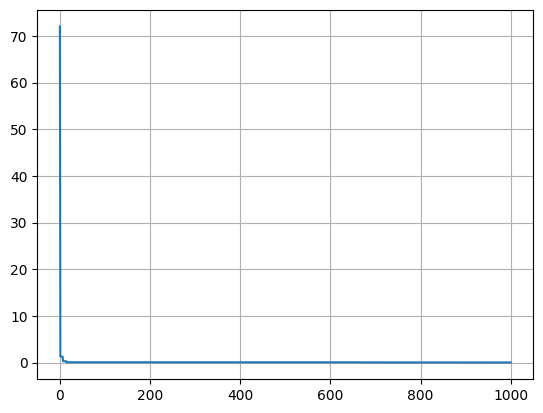

Algorytm zajął: 0.03216s
Step: 1	 Position: [2.78426, -2.53000]	 Value: 38.15916
Step: 4	 Position: [3.21034, 0.30906]	 Value: 13.79459
Step: 5	 Position: [3.15112, 1.10393]	 Value: 6.91917
Step: 6	 Position: [3.12990, 1.23642]	 Value: 5.48306
Step: 7	 Position: [3.29874, 1.33709]	 Value: 5.14677
Step: 8	 Position: [3.13527, 1.43020]	 Value: 3.37732
Step: 9	 Position: [3.06888, 1.51955]	 Value: 2.63505
Step: 14	 Position: [3.00926, 1.70611]	 Value: 1.22305
Step: 18	 Position: [3.03173, 1.70998]	 Value: 1.10019
Step: 21	 Position: [2.93019, 1.91743]	 Value: 0.40119
Step: 22	 Position: [3.03341, 1.93506]	 Value: 0.06801
Step: 32	 Position: [2.98888, 2.00600]	 Value: 0.00384
Step: 157	 Position: [2.99977, 1.99324]	 Value: 0.00081


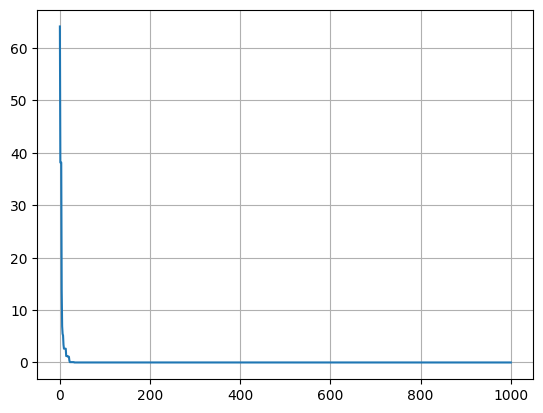

In [174]:
size = 5

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 10$

Algorytm zajął: 0.05222s
Step: 1	 Position: [4.34620, -1.04953]	 Value: 49.19471
Step: 2	 Position: [3.78227, -1.87213]	 Value: 2.13720
Step: 5	 Position: [3.62769, -1.95005]	 Value: 0.22934
Step: 35	 Position: [3.57699, -1.72683]	 Value: 0.19917
Step: 53	 Position: [3.62406, -1.79550]	 Value: 0.13760
Step: 109	 Position: [3.55334, -1.81075]	 Value: 0.06221
Step: 128	 Position: [3.59900, -1.84778]	 Value: 0.01121
Step: 197	 Position: [3.58357, -1.85006]	 Value: 0.00011


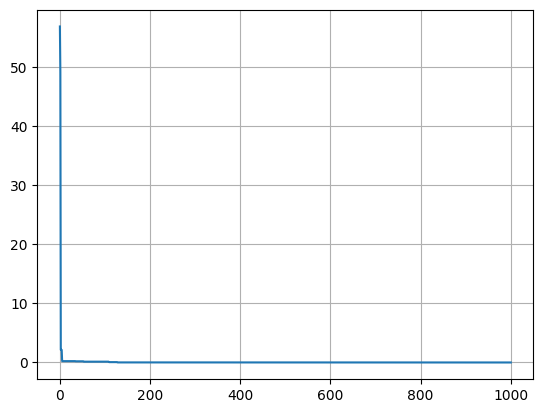

Algorytm zajął: 0.04831s
Step: 2	 Position: [2.94339, -3.00175]	 Value: 53.03710
Step: 3	 Position: [2.23102, 1.49244]	 Value: 26.98194
Step: 4	 Position: [2.34098, 1.44507]	 Value: 23.21258
Step: 5	 Position: [3.11929, 1.93319]	 Value: 0.46034
Step: 12	 Position: [2.92552, 1.96250]	 Value: 0.27902
Step: 22	 Position: [2.96316, 2.04837]	 Value: 0.05462
Step: 138	 Position: [3.01549, 1.98210]	 Value: 0.00878
Step: 186	 Position: [3.00212, 1.98611]	 Value: 0.00284
Step: 643	 Position: [3.00214, 1.99271]	 Value: 0.00076


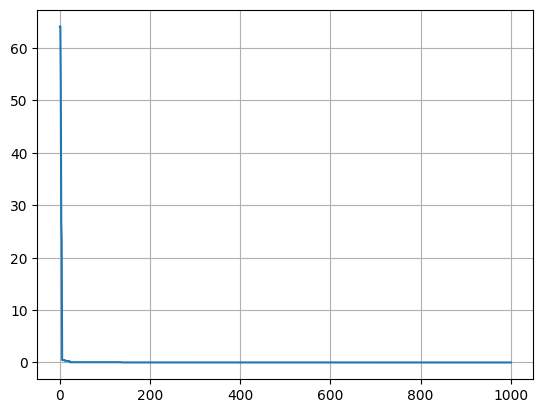

In [175]:
size = 10

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu =20$

Algorytm zajął: 0.09155s
Step: 1	 Position: [-3.53730, -3.50603]	 Value: 7.05397
Step: 3	 Position: [-3.65034, -3.05266]	 Value: 2.30272
Step: 7	 Position: [-3.76674, -3.45229]	 Value: 1.39578
Step: 17	 Position: [-3.68343, -3.26163]	 Value: 0.48369
Step: 23	 Position: [-3.83097, -3.24961]	 Value: 0.25553
Step: 25	 Position: [-3.76395, -3.33784]	 Value: 0.17139
Step: 29	 Position: [-3.80186, -3.26560]	 Value: 0.05452
Step: 269	 Position: [-3.76878, -3.27585]	 Value: 0.00662
Step: 293	 Position: [-3.77704, -3.29265]	 Value: 0.00487
Step: 752	 Position: [-3.77651, -3.28569]	 Value: 0.00093


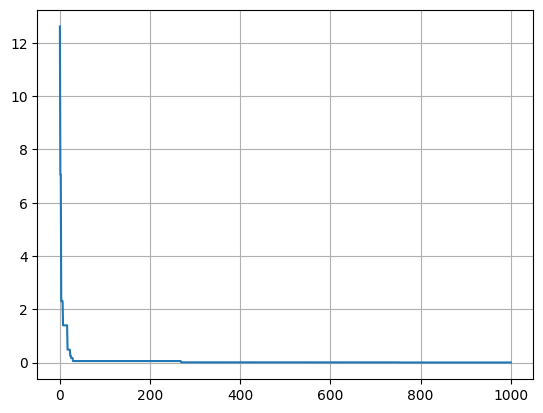

Algorytm zajął: 0.08983s
Step: 3	 Position: [2.09591, 0.86736]	 Value: 50.18261
Step: 4	 Position: [1.74302, 1.62286]	 Value: 47.06522
Step: 5	 Position: [2.41136, 1.17887]	 Value: 26.28491
Step: 6	 Position: [2.55746, 2.34796]	 Value: 5.60393
Step: 9	 Position: [2.85434, 2.50189]	 Value: 4.59122
Step: 10	 Position: [2.95799, 1.71381]	 Value: 1.50850
Step: 13	 Position: [3.14633, 1.90932]	 Value: 0.69740
Step: 17	 Position: [2.93875, 1.98101]	 Value: 0.16523
Step: 25	 Position: [2.95887, 2.09430]	 Value: 0.14174
Step: 26	 Position: [3.05564, 1.94580]	 Value: 0.10497
Step: 31	 Position: [3.01996, 1.98605]	 Value: 0.01255
Step: 61	 Position: [2.98245, 2.01051]	 Value: 0.00954
Step: 452	 Position: [2.99917, 2.02200]	 Value: 0.00797
Step: 798	 Position: [3.00486, 2.00239]	 Value: 0.00121


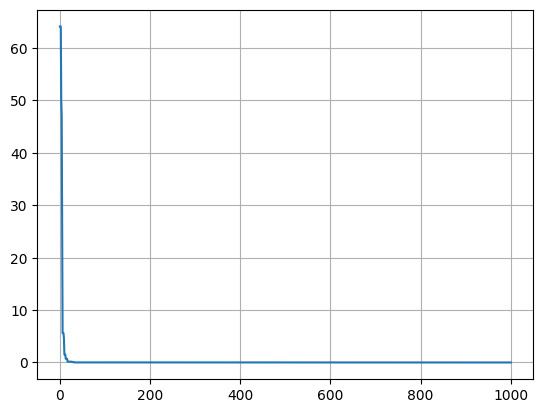

In [176]:
size = 20

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu =50$

Algorytm zajął: 0.19627s
Step: 1	 Position: [3.02954, 1.93574]	 Value: 0.06286
Step: 13	 Position: [2.98871, 2.02022]	 Value: 0.00714
Step: 152	 Position: [2.99710, 1.98197]	 Value: 0.00683
Step: 270	 Position: [3.00133, 2.01901]	 Value: 0.00677
Step: 372	 Position: [3.00367, 2.01495]	 Value: 0.00542
Step: 572	 Position: [3.00493, 2.01305]	 Value: 0.00510
Step: 885	 Position: [3.00119, 1.99711]	 Value: 0.00013


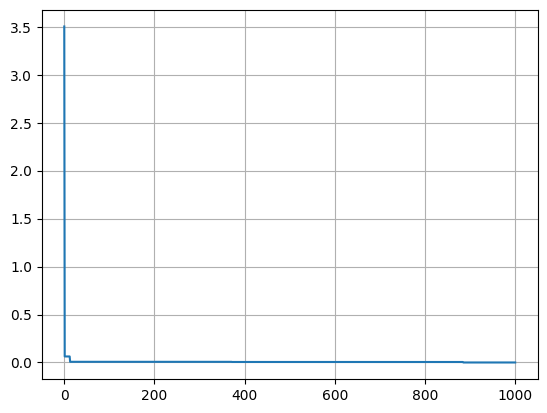

Algorytm zajął: 0.19259s
Step: 1	 Position: [2.61928, 2.71185]	 Value: 10.87888
Step: 2	 Position: [3.38544, -0.69839]	 Value: 9.83323
Step: 3	 Position: [3.34915, -1.20613]	 Value: 5.80173
Step: 4	 Position: [3.11758, 1.82888]	 Value: 0.58954
Step: 8	 Position: [2.96076, 1.95925]	 Value: 0.11565
Step: 10	 Position: [2.99765, 1.93496]	 Value: 0.07297
Step: 14	 Position: [2.97913, 1.99456]	 Value: 0.01877
Step: 91	 Position: [2.98862, 1.99060]	 Value: 0.00840
Step: 110	 Position: [3.00019, 2.01280]	 Value: 0.00285
Step: 842	 Position: [3.00515, 2.00387]	 Value: 0.00164


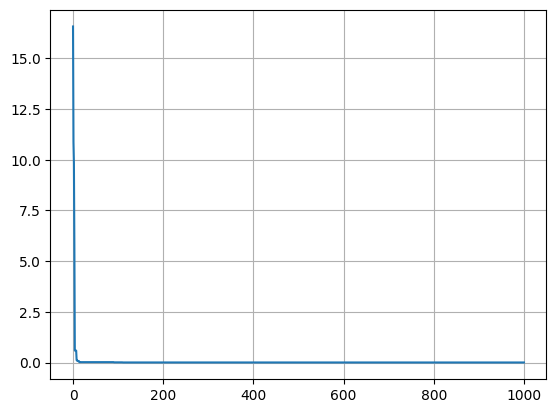

In [177]:
size = 50

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

#### Ackley function

##### $\mu =5$

Algorytm zajął: 0.06373s
Step: 4	 Position: [-0.26206, -0.35272]	 Value: 3.21053
Step: 6	 Position: [-0.74805, 0.01696]	 Value: 3.09249
Step: 7	 Position: [-0.06694, -0.30597]	 Value: 2.25616
Step: 12	 Position: [-0.25702, 0.01853]	 Value: 1.82668
Step: 18	 Position: [0.00008, 0.02058]	 Value: 0.06946
Step: 271	 Position: [-0.00747, 0.00145]	 Value: 0.02306


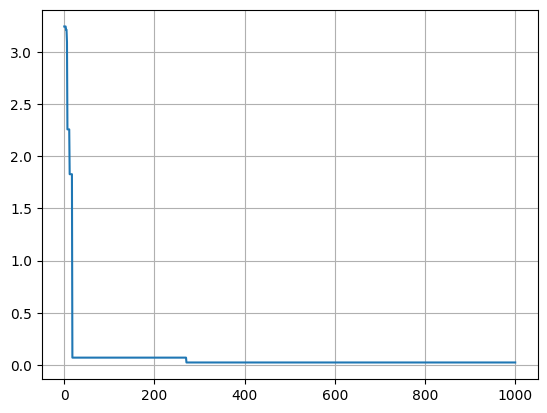

Algorytm zajął: 0.06587s
Step: 2	 Position: [1.20992, 1.36871]	 Value: 6.46504
Step: 4	 Position: [1.17507, 1.00531]	 Value: 4.57914
Step: 5	 Position: [0.94438, 0.98676]	 Value: 3.59848
Step: 10	 Position: [-0.00014, 1.10712]	 Value: 3.17937
Step: 11	 Position: [0.03048, 0.08258]	 Value: 0.44375
Step: 38	 Position: [-0.05986, 0.05681]	 Value: 0.40684
Step: 46	 Position: [-0.04563, -0.05484]	 Value: 0.33280
Step: 68	 Position: [0.01819, 0.00205]	 Value: 0.06067
Step: 667	 Position: [-0.01766, 0.00140]	 Value: 0.05844
Step: 712	 Position: [-0.01133, -0.00769]	 Value: 0.04370
Step: 851	 Position: [0.00097, 0.00839]	 Value: 0.02579


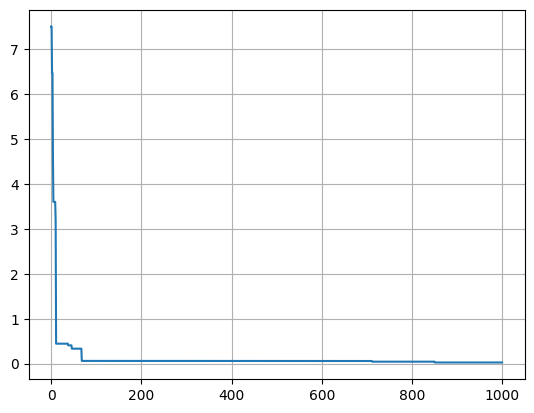

In [178]:
size = 5

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 10$

Algorytm zajął: 0.10673s
Step: 1	 Position: [-0.20448, -0.05343]	 Value: 1.46095
Step: 3	 Position: [-0.09464, -0.01968]	 Value: 0.50461
Step: 31	 Position: [0.06086, 0.03373]	 Value: 0.32142
Step: 50	 Position: [-0.00692, 0.03981]	 Value: 0.15718
Step: 63	 Position: [-0.01345, 0.00125]	 Value: 0.04307
Step: 70	 Position: [-0.00132, -0.01173]	 Value: 0.03711


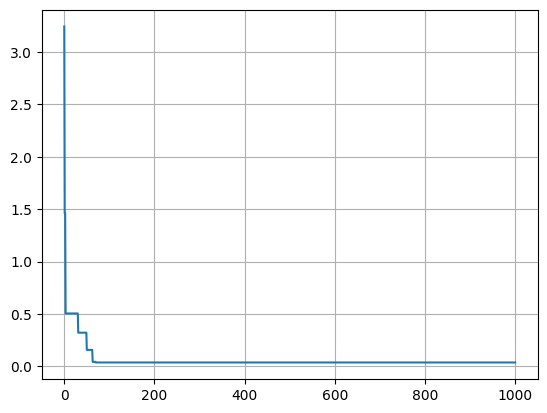

Algorytm zajął: 0.10929s
Step: 1	 Position: [1.37006, 0.98169]	 Value: 5.79307
Step: 2	 Position: [-1.17957, -0.92900]	 Value: 4.59968
Step: 4	 Position: [-0.87703, -1.08635]	 Value: 4.10677
Step: 5	 Position: [-0.23401, -0.89097]	 Value: 3.61260
Step: 9	 Position: [-0.19914, -0.88579]	 Value: 3.42282
Step: 10	 Position: [-0.72638, 0.06876]	 Value: 3.21660
Step: 11	 Position: [-0.43740, 0.06996]	 Value: 2.94204
Step: 13	 Position: [-0.09343, 0.40907]	 Value: 2.87486
Step: 19	 Position: [-0.05138, 0.27450]	 Value: 2.00470
Step: 25	 Position: [0.16870, -0.02933]	 Value: 1.10925
Step: 52	 Position: [0.01716, -0.14617]	 Value: 0.90328
Step: 56	 Position: [0.11228, 0.03407]	 Value: 0.66228
Step: 72	 Position: [0.07104, -0.03960]	 Value: 0.39822
Step: 91	 Position: [-0.04284, -0.00486]	 Value: 0.17072
Step: 110	 Position: [0.02514, 0.01665]	 Value: 0.10934
Step: 145	 Position: [0.01538, -0.01399]	 Value: 0.07030
Step: 186	 Position: [0.00202, -0.00999]	 Value: 0.03158
Step: 823	 Position: [0

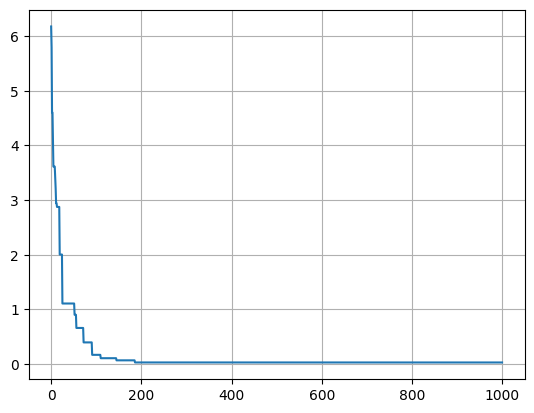

In [179]:
size = 10

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu = 20$

Algorytm zajął: 0.19884s
Step: 4	 Position: [-0.25579, 0.21625]	 Value: 2.55264
Step: 5	 Position: [-0.12209, -0.03798]	 Value: 0.74685
Step: 9	 Position: [0.05353, 0.06872]	 Value: 0.43851
Step: 37	 Position: [-0.03460, 0.05489]	 Value: 0.29246
Step: 38	 Position: [0.01057, -0.03064]	 Value: 0.11943
Step: 217	 Position: [0.00649, 0.01974]	 Value: 0.07025
Step: 235	 Position: [-0.01026, 0.00964]	 Value: 0.04509
Step: 738	 Position: [-0.00758, 0.00115]	 Value: 0.02326


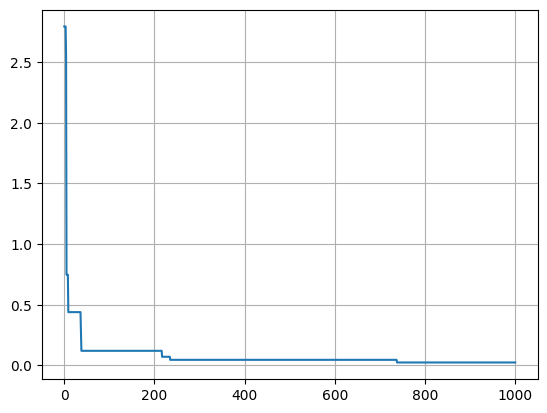

Algorytm zajął: 0.19970s
Step: 2	 Position: [0.29388, 0.30548]	 Value: 3.14628
Step: 3	 Position: [0.29849, 0.12022]	 Value: 2.36940
Step: 5	 Position: [0.01233, 0.31686]	 Value: 2.25277
Step: 13	 Position: [-0.27225, -0.01965]	 Value: 1.94368
Step: 15	 Position: [0.20398, -0.07398]	 Value: 1.51956
Step: 18	 Position: [-0.06805, -0.03055]	 Value: 0.35324
Step: 97	 Position: [0.00404, 0.05880]	 Value: 0.25664
Step: 126	 Position: [-0.04360, -0.00125]	 Value: 0.17322
Step: 175	 Position: [-0.03371, -0.01254]	 Value: 0.13582
Step: 210	 Position: [0.01073, 0.01964]	 Value: 0.07659
Step: 253	 Position: [0.00324, -0.00308]	 Value: 0.01318


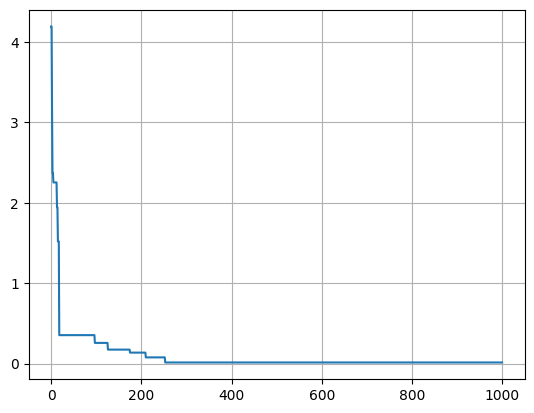

In [180]:
size = 20

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\mu =50$

Algorytm zajął: 0.46611s
Step: 2	 Position: [-0.23907, 0.09879]	 Value: 1.88241
Step: 7	 Position: [0.17859, 0.10706]	 Value: 1.46192
Step: 8	 Position: [0.03882, -0.14098]	 Value: 0.89866
Step: 16	 Position: [-0.05026, 0.04227]	 Value: 0.29735
Step: 22	 Position: [0.03459, -0.03004]	 Value: 0.18473
Step: 65	 Position: [0.04167, -0.01884]	 Value: 0.18418
Step: 68	 Position: [0.04185, -0.01243]	 Value: 0.17350
Step: 86	 Position: [0.03365, -0.01554]	 Value: 0.14104
Step: 114	 Position: [0.01199, -0.01320]	 Value: 0.05891
Step: 243	 Position: [0.01582, 0.00706]	 Value: 0.05698
Step: 964	 Position: [0.01590, 0.00462]	 Value: 0.05411
Step: 999	 Position: [0.00729, 0.00026]	 Value: 0.02206


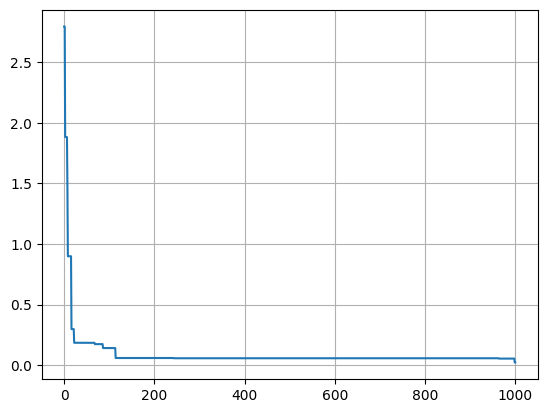

Algorytm zajął: 0.46462s
Step: 1	 Position: [0.21808, 0.02140]	 Value: 1.51538
Step: 3	 Position: [-0.19130, -0.00982]	 Value: 1.28029
Step: 5	 Position: [-0.15784, -0.05764]	 Value: 1.08952
Step: 11	 Position: [0.03811, -0.06968]	 Value: 0.38529
Step: 14	 Position: [0.01958, -0.01007]	 Value: 0.07516
Step: 63	 Position: [-0.00632, -0.01078]	 Value: 0.03949
Step: 116	 Position: [-0.00331, -0.00822]	 Value: 0.02717
Step: 174	 Position: [0.00405, 0.00747]	 Value: 0.02594


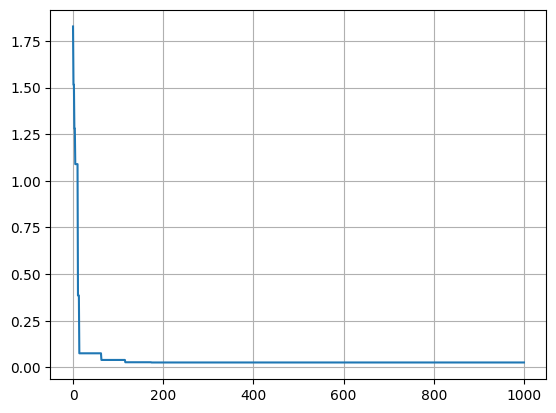

In [181]:
size = 50

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

### Ilość iteracji - $t$

In [182]:
restrictions = ((-7,7),(-7,7))
size = 20
mutation_strength = 0.3
crossover_probability =  0.1

#### Himmelblau function

##### $t = 50$

Algorytm zajął: 0.00440s
Step: 1	 Position: [-3.53730, -3.50603]	 Value: 7.05397
Step: 3	 Position: [-3.65034, -3.05266]	 Value: 2.30272
Step: 7	 Position: [-3.76674, -3.45229]	 Value: 1.39578
Step: 17	 Position: [-3.68343, -3.26163]	 Value: 0.48369
Step: 23	 Position: [-3.83097, -3.24961]	 Value: 0.25553
Step: 25	 Position: [-3.76395, -3.33784]	 Value: 0.17139
Step: 29	 Position: [-3.80186, -3.26560]	 Value: 0.05452


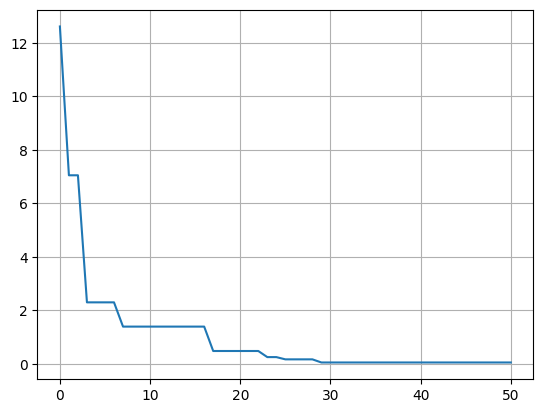

Algorytm zajął: 0.00407s
Step: 3	 Position: [2.09591, 0.86736]	 Value: 50.18261
Step: 4	 Position: [1.74302, 1.62286]	 Value: 47.06522
Step: 5	 Position: [2.41136, 1.17887]	 Value: 26.28491
Step: 6	 Position: [2.55746, 2.34796]	 Value: 5.60393
Step: 9	 Position: [2.85434, 2.50189]	 Value: 4.59122
Step: 10	 Position: [2.95799, 1.71381]	 Value: 1.50850
Step: 13	 Position: [3.14633, 1.90932]	 Value: 0.69740
Step: 17	 Position: [2.93875, 1.98101]	 Value: 0.16523
Step: 25	 Position: [2.95887, 2.09430]	 Value: 0.14174
Step: 26	 Position: [3.05564, 1.94580]	 Value: 0.10497
Step: 31	 Position: [3.01996, 1.98605]	 Value: 0.01255


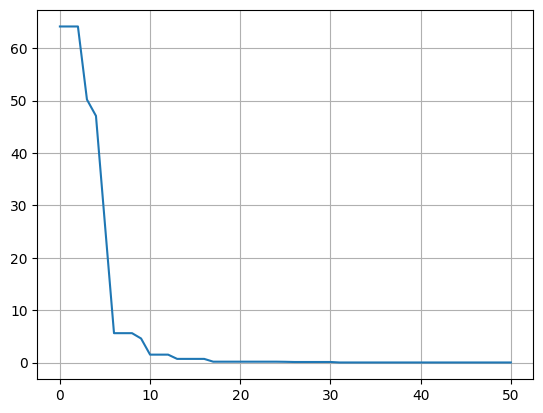

In [183]:
iterations = 50

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 100$

Algorytm zajął: 0.00872s
Step: 1	 Position: [-3.53730, -3.50603]	 Value: 7.05397
Step: 3	 Position: [-3.65034, -3.05266]	 Value: 2.30272
Step: 7	 Position: [-3.76674, -3.45229]	 Value: 1.39578
Step: 17	 Position: [-3.68343, -3.26163]	 Value: 0.48369
Step: 23	 Position: [-3.83097, -3.24961]	 Value: 0.25553
Step: 25	 Position: [-3.76395, -3.33784]	 Value: 0.17139
Step: 29	 Position: [-3.80186, -3.26560]	 Value: 0.05452


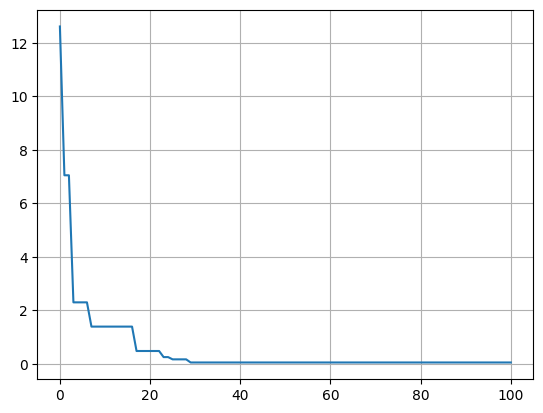

Algorytm zajął: 0.00864s
Step: 3	 Position: [2.09591, 0.86736]	 Value: 50.18261
Step: 4	 Position: [1.74302, 1.62286]	 Value: 47.06522
Step: 5	 Position: [2.41136, 1.17887]	 Value: 26.28491
Step: 6	 Position: [2.55746, 2.34796]	 Value: 5.60393
Step: 9	 Position: [2.85434, 2.50189]	 Value: 4.59122
Step: 10	 Position: [2.95799, 1.71381]	 Value: 1.50850
Step: 13	 Position: [3.14633, 1.90932]	 Value: 0.69740
Step: 17	 Position: [2.93875, 1.98101]	 Value: 0.16523
Step: 25	 Position: [2.95887, 2.09430]	 Value: 0.14174
Step: 26	 Position: [3.05564, 1.94580]	 Value: 0.10497
Step: 31	 Position: [3.01996, 1.98605]	 Value: 0.01255
Step: 61	 Position: [2.98245, 2.01051]	 Value: 0.00954


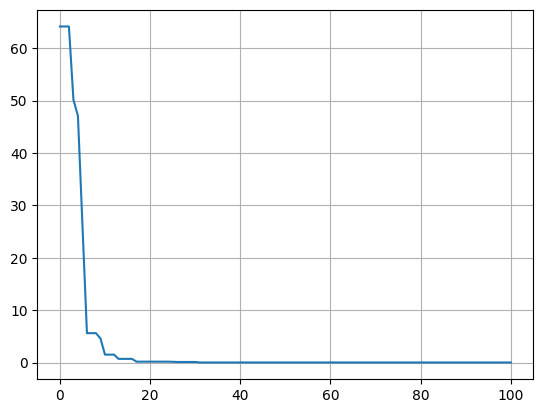

In [184]:
iterations = 100

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 1000$

Algorytm zajął: 0.08765s
Step: 1	 Position: [-3.53730, -3.50603]	 Value: 7.05397
Step: 3	 Position: [-3.65034, -3.05266]	 Value: 2.30272
Step: 7	 Position: [-3.76674, -3.45229]	 Value: 1.39578
Step: 17	 Position: [-3.68343, -3.26163]	 Value: 0.48369
Step: 23	 Position: [-3.83097, -3.24961]	 Value: 0.25553
Step: 25	 Position: [-3.76395, -3.33784]	 Value: 0.17139
Step: 29	 Position: [-3.80186, -3.26560]	 Value: 0.05452
Step: 269	 Position: [-3.76878, -3.27585]	 Value: 0.00662
Step: 293	 Position: [-3.77704, -3.29265]	 Value: 0.00487
Step: 752	 Position: [-3.77651, -3.28569]	 Value: 0.00093


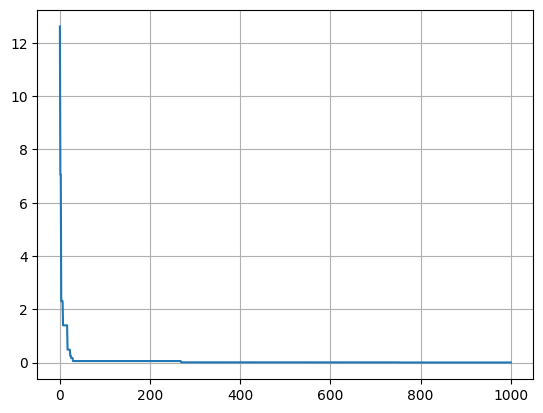

Algorytm zajął: 0.09000s
Step: 3	 Position: [2.09591, 0.86736]	 Value: 50.18261
Step: 4	 Position: [1.74302, 1.62286]	 Value: 47.06522
Step: 5	 Position: [2.41136, 1.17887]	 Value: 26.28491
Step: 6	 Position: [2.55746, 2.34796]	 Value: 5.60393
Step: 9	 Position: [2.85434, 2.50189]	 Value: 4.59122
Step: 10	 Position: [2.95799, 1.71381]	 Value: 1.50850
Step: 13	 Position: [3.14633, 1.90932]	 Value: 0.69740
Step: 17	 Position: [2.93875, 1.98101]	 Value: 0.16523
Step: 25	 Position: [2.95887, 2.09430]	 Value: 0.14174
Step: 26	 Position: [3.05564, 1.94580]	 Value: 0.10497
Step: 31	 Position: [3.01996, 1.98605]	 Value: 0.01255
Step: 61	 Position: [2.98245, 2.01051]	 Value: 0.00954
Step: 452	 Position: [2.99917, 2.02200]	 Value: 0.00797
Step: 798	 Position: [3.00486, 2.00239]	 Value: 0.00121


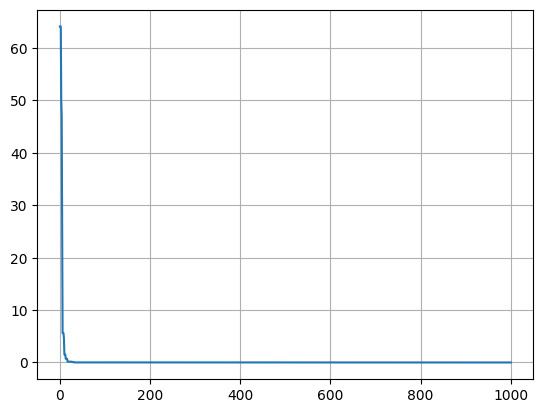

In [185]:
iterations = 1000

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 10000$

Algorytm zajął: 0.86699s
Step: 1	 Position: [-3.53730, -3.50603]	 Value: 7.05397
Step: 3	 Position: [-3.65034, -3.05266]	 Value: 2.30272
Step: 7	 Position: [-3.76674, -3.45229]	 Value: 1.39578
Step: 17	 Position: [-3.68343, -3.26163]	 Value: 0.48369
Step: 23	 Position: [-3.83097, -3.24961]	 Value: 0.25553
Step: 25	 Position: [-3.76395, -3.33784]	 Value: 0.17139
Step: 29	 Position: [-3.80186, -3.26560]	 Value: 0.05452
Step: 269	 Position: [-3.76878, -3.27585]	 Value: 0.00662
Step: 293	 Position: [-3.77704, -3.29265]	 Value: 0.00487
Step: 752	 Position: [-3.77651, -3.28569]	 Value: 0.00093
Step: 1078	 Position: [-3.77797, -3.28027]	 Value: 0.00037


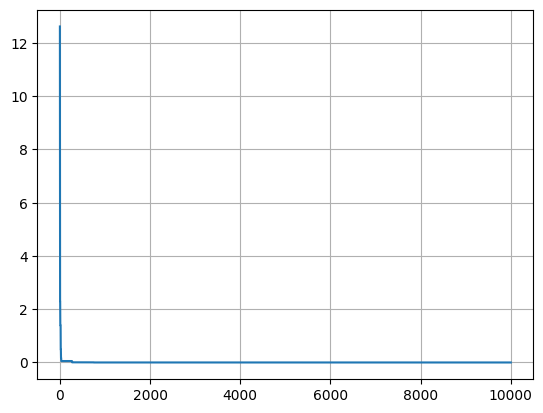

Algorytm zajął: 0.86922s
Step: 3	 Position: [2.09591, 0.86736]	 Value: 50.18261
Step: 4	 Position: [1.74302, 1.62286]	 Value: 47.06522
Step: 5	 Position: [2.41136, 1.17887]	 Value: 26.28491
Step: 6	 Position: [2.55746, 2.34796]	 Value: 5.60393
Step: 9	 Position: [2.85434, 2.50189]	 Value: 4.59122
Step: 10	 Position: [2.95799, 1.71381]	 Value: 1.50850
Step: 13	 Position: [3.14633, 1.90932]	 Value: 0.69740
Step: 17	 Position: [2.93875, 1.98101]	 Value: 0.16523
Step: 25	 Position: [2.95887, 2.09430]	 Value: 0.14174
Step: 26	 Position: [3.05564, 1.94580]	 Value: 0.10497
Step: 31	 Position: [3.01996, 1.98605]	 Value: 0.01255
Step: 61	 Position: [2.98245, 2.01051]	 Value: 0.00954
Step: 452	 Position: [2.99917, 2.02200]	 Value: 0.00797
Step: 798	 Position: [3.00486, 2.00239]	 Value: 0.00121
Step: 1235	 Position: [3.00328, 1.99135]	 Value: 0.00110
Step: 2527	 Position: [2.99540, 2.00385]	 Value: 0.00068
Step: 4834	 Position: [3.00064, 1.99423]	 Value: 0.00050


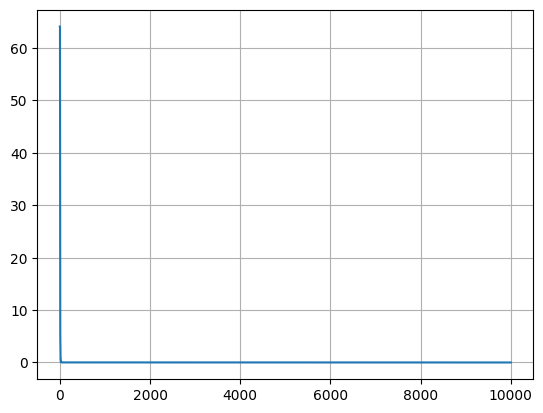

In [186]:
iterations = 10000

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

#### Ackley function

##### $t = 50$

Algorytm zajął: 0.01002s
Step: 4	 Position: [-0.25579, 0.21625]	 Value: 2.55264
Step: 5	 Position: [-0.12209, -0.03798]	 Value: 0.74685
Step: 9	 Position: [0.05353, 0.06872]	 Value: 0.43851
Step: 37	 Position: [-0.03460, 0.05489]	 Value: 0.29246
Step: 38	 Position: [0.01057, -0.03064]	 Value: 0.11943


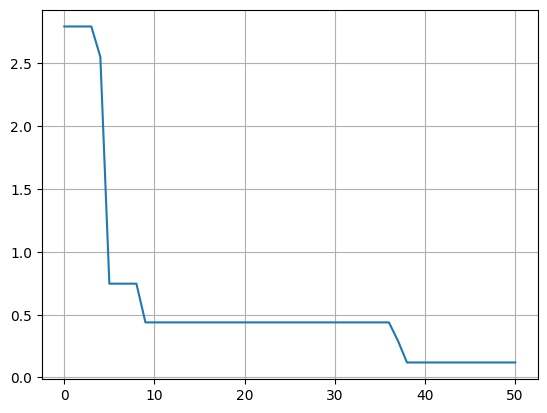

Algorytm zajął: 0.01153s
Step: 2	 Position: [0.29388, 0.30548]	 Value: 3.14628
Step: 3	 Position: [0.29849, 0.12022]	 Value: 2.36940
Step: 5	 Position: [0.01233, 0.31686]	 Value: 2.25277
Step: 13	 Position: [-0.27225, -0.01965]	 Value: 1.94368
Step: 15	 Position: [0.20398, -0.07398]	 Value: 1.51956
Step: 18	 Position: [-0.06805, -0.03055]	 Value: 0.35324


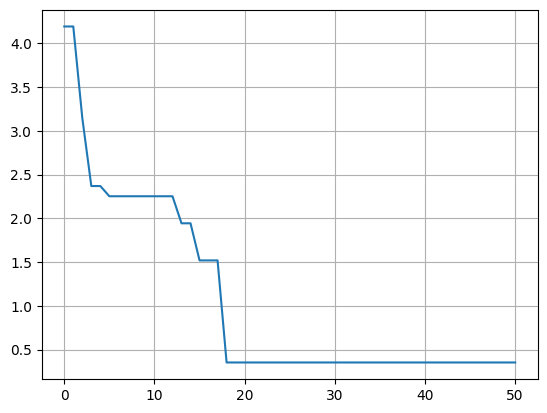

In [187]:
iterations = 50

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 100$

Algorytm zajął: 0.02109s
Step: 4	 Position: [-0.25579, 0.21625]	 Value: 2.55264
Step: 5	 Position: [-0.12209, -0.03798]	 Value: 0.74685
Step: 9	 Position: [0.05353, 0.06872]	 Value: 0.43851
Step: 37	 Position: [-0.03460, 0.05489]	 Value: 0.29246
Step: 38	 Position: [0.01057, -0.03064]	 Value: 0.11943


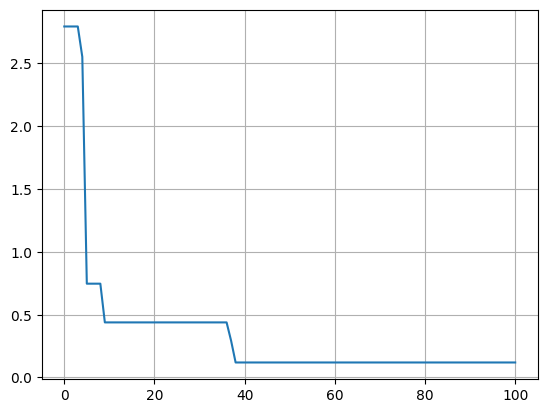

Algorytm zajął: 0.02008s
Step: 2	 Position: [0.29388, 0.30548]	 Value: 3.14628
Step: 3	 Position: [0.29849, 0.12022]	 Value: 2.36940
Step: 5	 Position: [0.01233, 0.31686]	 Value: 2.25277
Step: 13	 Position: [-0.27225, -0.01965]	 Value: 1.94368
Step: 15	 Position: [0.20398, -0.07398]	 Value: 1.51956
Step: 18	 Position: [-0.06805, -0.03055]	 Value: 0.35324
Step: 97	 Position: [0.00404, 0.05880]	 Value: 0.25664


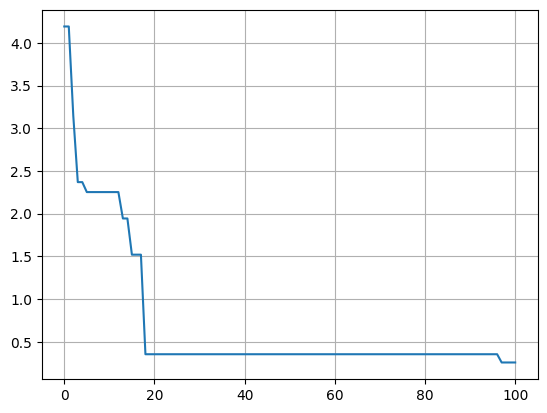

In [188]:
iterations = 100

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 1000$

Algorytm zajął: 0.20038s
Step: 4	 Position: [-0.25579, 0.21625]	 Value: 2.55264
Step: 5	 Position: [-0.12209, -0.03798]	 Value: 0.74685
Step: 9	 Position: [0.05353, 0.06872]	 Value: 0.43851
Step: 37	 Position: [-0.03460, 0.05489]	 Value: 0.29246
Step: 38	 Position: [0.01057, -0.03064]	 Value: 0.11943
Step: 217	 Position: [0.00649, 0.01974]	 Value: 0.07025
Step: 235	 Position: [-0.01026, 0.00964]	 Value: 0.04509
Step: 738	 Position: [-0.00758, 0.00115]	 Value: 0.02326


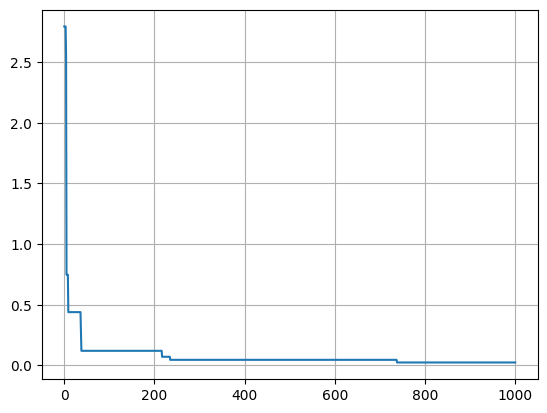

Algorytm zajął: 0.19901s
Step: 2	 Position: [0.29388, 0.30548]	 Value: 3.14628
Step: 3	 Position: [0.29849, 0.12022]	 Value: 2.36940
Step: 5	 Position: [0.01233, 0.31686]	 Value: 2.25277
Step: 13	 Position: [-0.27225, -0.01965]	 Value: 1.94368
Step: 15	 Position: [0.20398, -0.07398]	 Value: 1.51956
Step: 18	 Position: [-0.06805, -0.03055]	 Value: 0.35324
Step: 97	 Position: [0.00404, 0.05880]	 Value: 0.25664
Step: 126	 Position: [-0.04360, -0.00125]	 Value: 0.17322
Step: 175	 Position: [-0.03371, -0.01254]	 Value: 0.13582
Step: 210	 Position: [0.01073, 0.01964]	 Value: 0.07659
Step: 253	 Position: [0.00324, -0.00308]	 Value: 0.01318


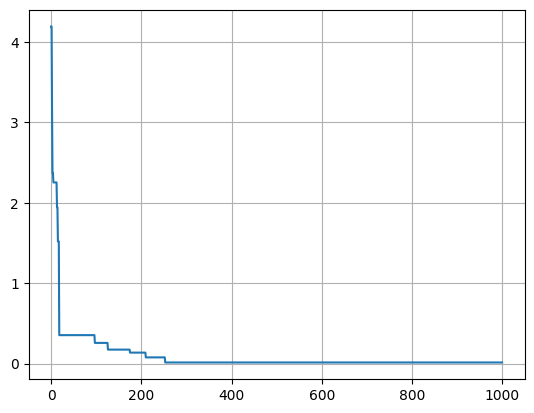

In [189]:
iterations = 1000

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $t = 10000$

Algorytm zajął: 1.97297s
Step: 4	 Position: [-0.25579, 0.21625]	 Value: 2.55264
Step: 5	 Position: [-0.12209, -0.03798]	 Value: 0.74685
Step: 9	 Position: [0.05353, 0.06872]	 Value: 0.43851
Step: 37	 Position: [-0.03460, 0.05489]	 Value: 0.29246
Step: 38	 Position: [0.01057, -0.03064]	 Value: 0.11943
Step: 217	 Position: [0.00649, 0.01974]	 Value: 0.07025
Step: 235	 Position: [-0.01026, 0.00964]	 Value: 0.04509
Step: 738	 Position: [-0.00758, 0.00115]	 Value: 0.02326
Step: 1095	 Position: [-0.00523, 0.00389]	 Value: 0.01956
Step: 2351	 Position: [-0.00013, -0.00333]	 Value: 0.00973


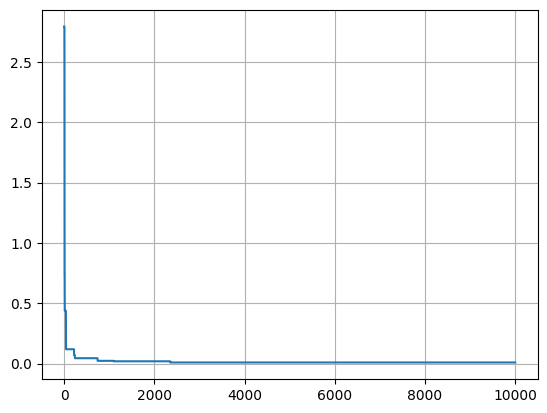

Algorytm zajął: 1.96745s
Step: 2	 Position: [0.29388, 0.30548]	 Value: 3.14628
Step: 3	 Position: [0.29849, 0.12022]	 Value: 2.36940
Step: 5	 Position: [0.01233, 0.31686]	 Value: 2.25277
Step: 13	 Position: [-0.27225, -0.01965]	 Value: 1.94368
Step: 15	 Position: [0.20398, -0.07398]	 Value: 1.51956
Step: 18	 Position: [-0.06805, -0.03055]	 Value: 0.35324
Step: 97	 Position: [0.00404, 0.05880]	 Value: 0.25664
Step: 126	 Position: [-0.04360, -0.00125]	 Value: 0.17322
Step: 175	 Position: [-0.03371, -0.01254]	 Value: 0.13582
Step: 210	 Position: [0.01073, 0.01964]	 Value: 0.07659
Step: 253	 Position: [0.00324, -0.00308]	 Value: 0.01318
Step: 5790	 Position: [0.00201, 0.00184]	 Value: 0.00790
Step: 7862	 Position: [0.00166, -0.00112]	 Value: 0.00576


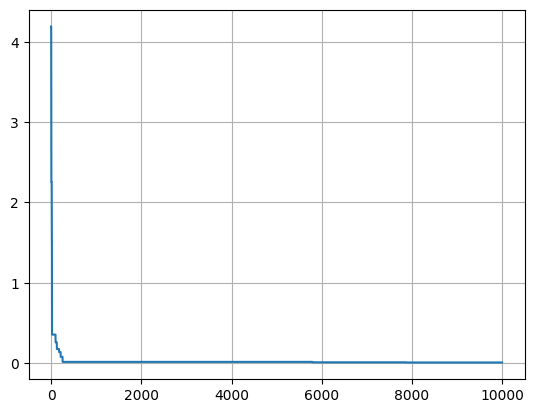

In [190]:
iterations = 10000

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

### Siła mutacji - $\sigma$

In [191]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
size = 20
crossover_probability =  0.1

#### Himmelblau function

##### $\sigma=0.5$

Algorytm zajął: 0.08740s
Step: 1	 Position: [-3.40429, -3.33147]	 Value: 8.00221
Step: 5	 Position: [-4.12513, -3.41848]	 Value: 7.06513
Step: 7	 Position: [-3.62128, -3.21454]	 Value: 1.29480
Step: 16	 Position: [-3.71573, -3.23818]	 Value: 0.23905
Step: 65	 Position: [-3.81196, -3.31759]	 Value: 0.08339
Step: 444	 Position: [-3.77059, -3.26524]	 Value: 0.01413
Step: 651	 Position: [-3.78534, -3.29945]	 Value: 0.01107
Step: 752	 Position: [-3.78446, -3.28784]	 Value: 0.00182


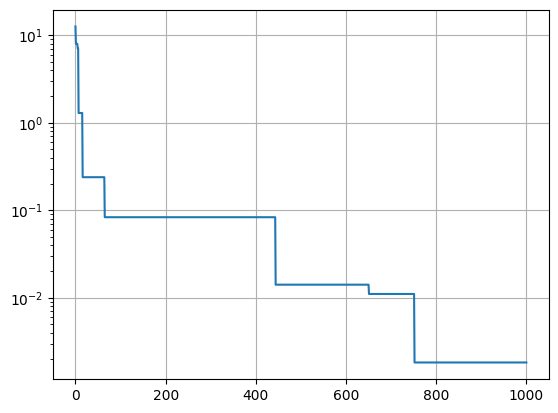

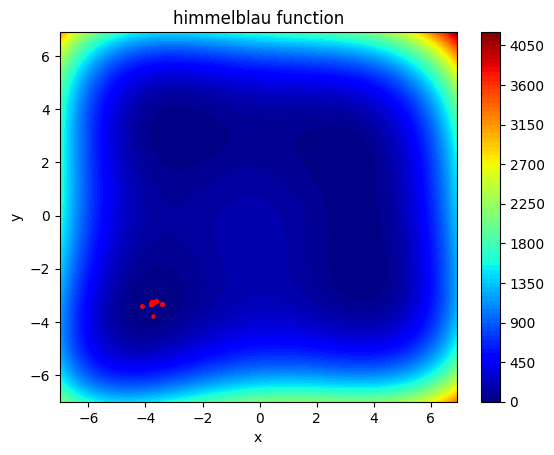

Algorytm zajął: 0.09085s
Step: 1	 Position: [-1.20358, 3.60324]	 Value: 58.22624
Step: 2	 Position: [-2.59378, 3.38693]	 Value: 4.30900
Step: 6	 Position: [-2.86169, 3.36950]	 Value: 2.53788
Step: 7	 Position: [-3.00662, 3.04707]	 Value: 1.70254
Step: 10	 Position: [3.11777, 1.69370]	 Value: 1.19900
Step: 18	 Position: [3.00878, 1.80308]	 Value: 0.56855
Step: 25	 Position: [3.04231, 1.99191]	 Value: 0.06140
Step: 31	 Position: [2.98286, 2.05899]	 Value: 0.05132
Step: 59	 Position: [2.99858, 2.02668]	 Value: 0.01157


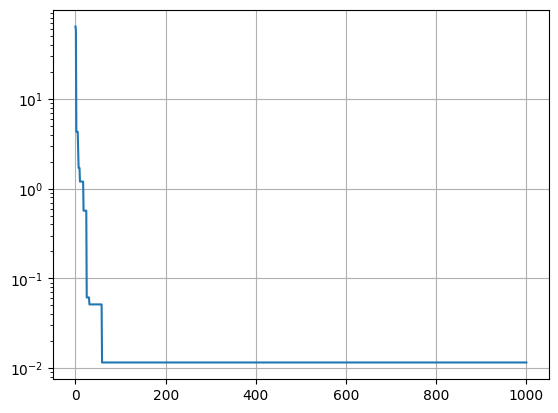

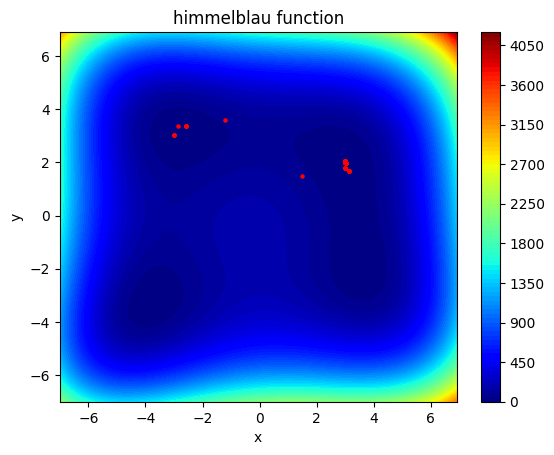

In [192]:
mutation_strength = 0.5

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)



random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

##### $\sigma=0.3$

Algorytm zajął: 0.08828s
Step: 1	 Position: [-3.53730, -3.50603]	 Value: 7.05397
Step: 3	 Position: [-3.65034, -3.05266]	 Value: 2.30272
Step: 7	 Position: [-3.76674, -3.45229]	 Value: 1.39578
Step: 17	 Position: [-3.68343, -3.26163]	 Value: 0.48369
Step: 23	 Position: [-3.83097, -3.24961]	 Value: 0.25553
Step: 25	 Position: [-3.76395, -3.33784]	 Value: 0.17139
Step: 29	 Position: [-3.80186, -3.26560]	 Value: 0.05452
Step: 269	 Position: [-3.76878, -3.27585]	 Value: 0.00662
Step: 293	 Position: [-3.77704, -3.29265]	 Value: 0.00487
Step: 752	 Position: [-3.77651, -3.28569]	 Value: 0.00093


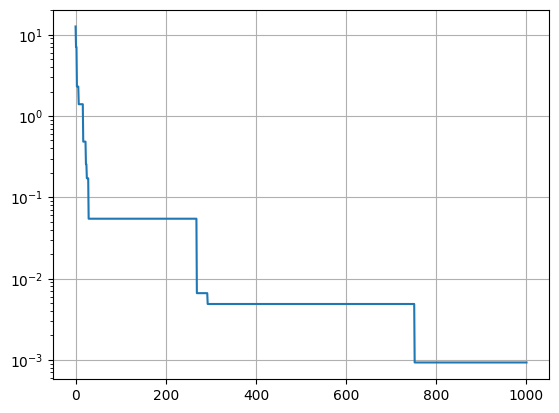

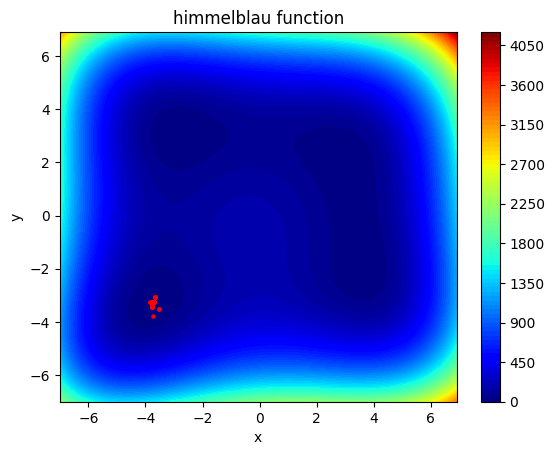

Algorytm zajął: 0.08591s
Step: 3	 Position: [2.09591, 0.86736]	 Value: 50.18261
Step: 4	 Position: [1.74302, 1.62286]	 Value: 47.06522
Step: 5	 Position: [2.41136, 1.17887]	 Value: 26.28491
Step: 6	 Position: [2.55746, 2.34796]	 Value: 5.60393
Step: 9	 Position: [2.85434, 2.50189]	 Value: 4.59122
Step: 10	 Position: [2.95799, 1.71381]	 Value: 1.50850
Step: 13	 Position: [3.14633, 1.90932]	 Value: 0.69740
Step: 17	 Position: [2.93875, 1.98101]	 Value: 0.16523
Step: 25	 Position: [2.95887, 2.09430]	 Value: 0.14174
Step: 26	 Position: [3.05564, 1.94580]	 Value: 0.10497
Step: 31	 Position: [3.01996, 1.98605]	 Value: 0.01255
Step: 61	 Position: [2.98245, 2.01051]	 Value: 0.00954
Step: 452	 Position: [2.99917, 2.02200]	 Value: 0.00797
Step: 798	 Position: [3.00486, 2.00239]	 Value: 0.00121


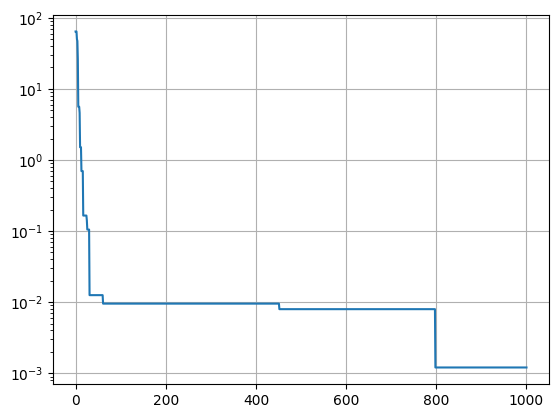

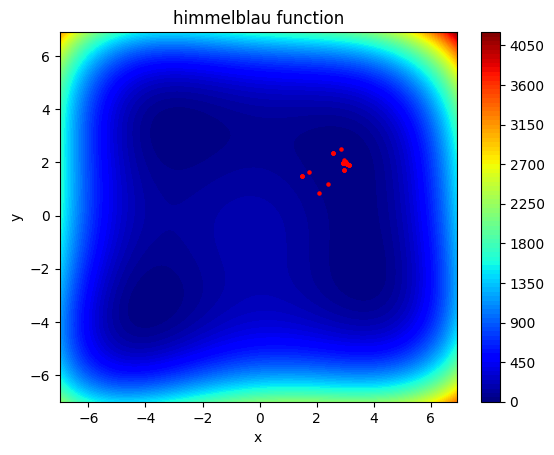

In [193]:
mutation_strength = 0.3

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)



random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


##### $\sigma=0.1$

Algorytm zajął: 0.08981s
Step: 1	 Position: [-3.67031, -3.68059]	 Value: 9.73646
Step: 3	 Position: [-3.70799, -3.52946]	 Value: 3.66823
Step: 6	 Position: [-3.86510, -3.31496]	 Value: 0.40477
Step: 9	 Position: [-3.82399, -3.34287]	 Value: 0.20147
Step: 18	 Position: [-3.79618, -3.30803]	 Value: 0.03217
Step: 29	 Position: [-3.78208, -3.27474]	 Value: 0.00424
Step: 216	 Position: [-3.77280, -3.28315]	 Value: 0.00245
Step: 337	 Position: [-3.78129, -3.28588]	 Value: 0.00040


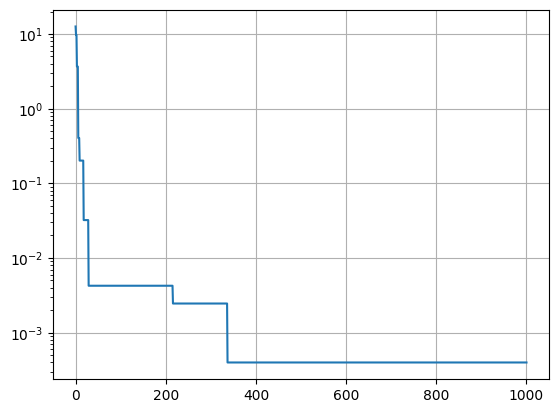

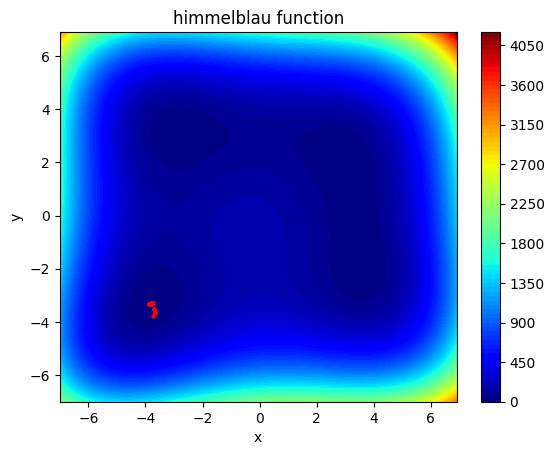

Algorytm zajął: 0.08704s
Step: 4	 Position: [1.57135, 1.47601]	 Value: 60.33333
Step: 5	 Position: [1.58837, 1.59906]	 Value: 55.45621
Step: 6	 Position: [1.83048, 1.62240]	 Value: 42.76196
Step: 8	 Position: [2.06592, 1.89113]	 Value: 25.27711
Step: 9	 Position: [2.58453, 1.48016]	 Value: 13.01473
Step: 10	 Position: [2.71991, 1.60267]	 Value: 6.92695
Step: 11	 Position: [2.83542, 1.54455]	 Value: 5.16913
Step: 12	 Position: [2.93126, 1.58170]	 Value: 3.13762
Step: 14	 Position: [3.09363, 1.67905]	 Value: 1.24419
Step: 15	 Position: [3.06010, 1.73663]	 Value: 0.86398
Step: 17	 Position: [3.11841, 1.91519]	 Value: 0.45485
Step: 18	 Position: [3.00920, 1.87763]	 Value: 0.22101
Step: 20	 Position: [3.02130, 1.89155]	 Value: 0.16099
Step: 24	 Position: [3.04773, 1.95065]	 Value: 0.07894
Step: 25	 Position: [2.96846, 1.99124]	 Value: 0.04323
Step: 26	 Position: [3.01302, 1.97272]	 Value: 0.01170
Step: 31	 Position: [3.00113, 1.98614]	 Value: 0.00298
Step: 50	 Position: [2.99572, 2.00575]	 

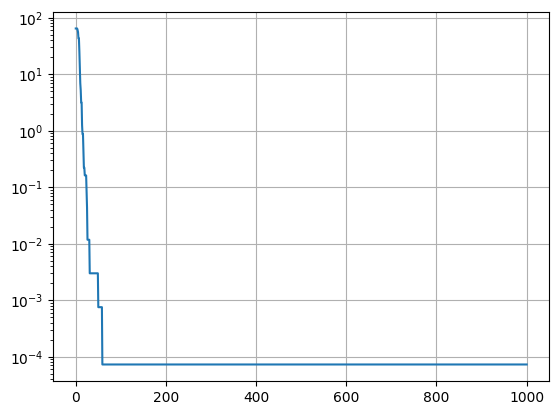

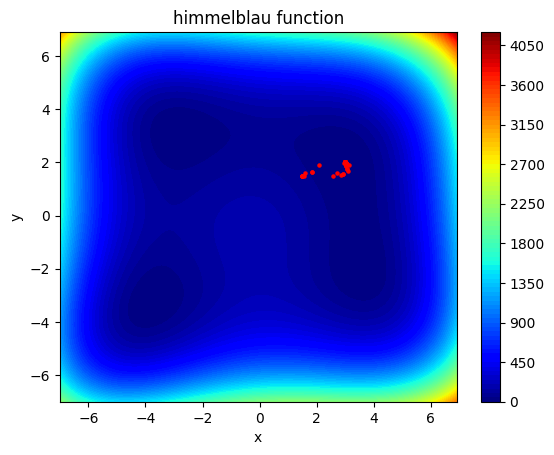

In [194]:
mutation_strength = 0.1

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)



random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace, True)
plot_trace(himmelblau_function,trace)


##### $\sigma=0.01$

Algorytm zajął: 0.08946s
Step: 1	 Position: [-3.73017, -3.75914]	 Value: 12.28061
Step: 3	 Position: [-3.73394, -3.74403]	 Value: 11.42622
Step: 4	 Position: [-3.69979, -3.72719]	 Value: 11.26908
Step: 5	 Position: [-3.72320, -3.71667]	 Value: 10.28085
Step: 6	 Position: [-3.69756, -3.68630]	 Value: 9.38814
Step: 7	 Position: [-3.72578, -3.67686]	 Value: 8.43651
Step: 9	 Position: [-3.73556, -3.67187]	 Value: 8.06100
Step: 10	 Position: [-3.70010, -3.61296]	 Value: 6.38889
Step: 11	 Position: [-3.69796, -3.61104]	 Value: 6.35962
Step: 12	 Position: [-3.72775, -3.61191]	 Value: 5.88607
Step: 13	 Position: [-3.76820, -3.61852]	 Value: 5.58368
Step: 14	 Position: [-3.78575, -3.61986]	 Value: 5.45453
Step: 15	 Position: [-3.80839, -3.58481]	 Value: 4.17835
Step: 16	 Position: [-3.81119, -3.56795]	 Value: 3.68479
Step: 17	 Position: [-3.78605, -3.54660]	 Value: 3.25762
Step: 18	 Position: [-3.80021, -3.51039]	 Value: 2.32306
Step: 22	 Position: [-3.78949, -3.50275]	 Value: 2.21004
Step: 24	

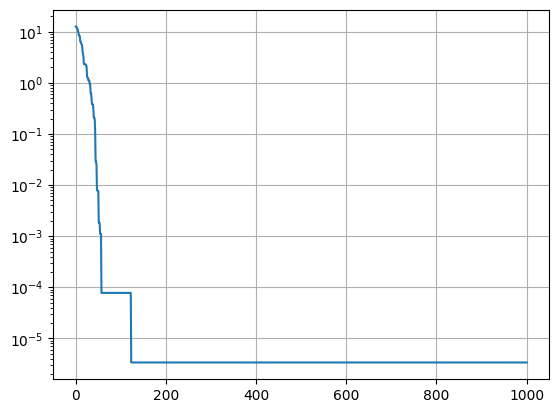

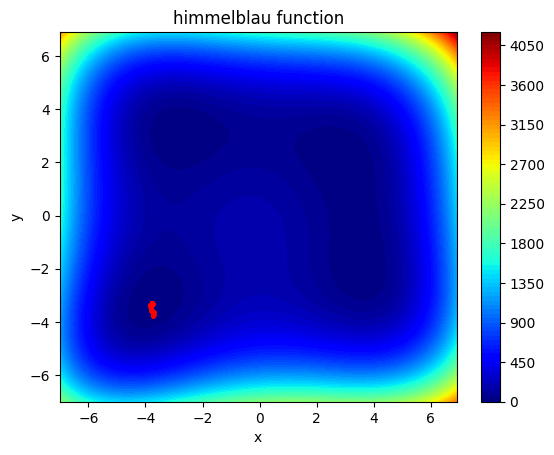

Algorytm zajął: 0.08750s
Step: 4	 Position: [1.49203, 1.49330]	 Value: 63.75160
Step: 5	 Position: [1.49373, 1.50561]	 Value: 63.24718
Step: 6	 Position: [1.51794, 1.50794]	 Value: 61.95826
Step: 8	 Position: [1.54149, 1.53481]	 Value: 59.88160
Step: 9	 Position: [1.59335, 1.49372]	 Value: 58.62987
Step: 10	 Position: [1.60689, 1.50597]	 Value: 57.54164
Step: 11	 Position: [1.61844, 1.50016]	 Value: 57.14498
Step: 12	 Position: [1.62802, 1.50387]	 Value: 56.53745
Step: 14	 Position: [1.62634, 1.53970]	 Value: 55.46648
Step: 15	 Position: [1.64091, 1.51936]	 Value: 55.38410
Step: 16	 Position: [1.65818, 1.53156]	 Value: 54.12003
Step: 18	 Position: [1.65874, 1.54463]	 Value: 53.67703
Step: 19	 Position: [1.62717, 1.59780]	 Value: 53.57520
Step: 20	 Position: [1.65579, 1.61320]	 Value: 51.67563
Step: 21	 Position: [1.68519, 1.60528]	 Value: 50.46196
Step: 22	 Position: [1.69811, 1.59001]	 Value: 50.28785
Step: 23	 Position: [1.69076, 1.61976]	 Value: 49.74342
Step: 24	 Position: [1.69602

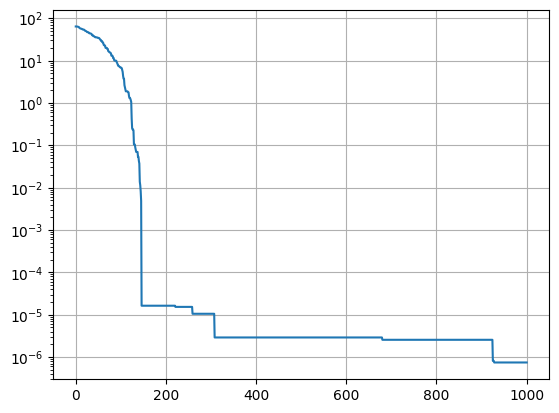

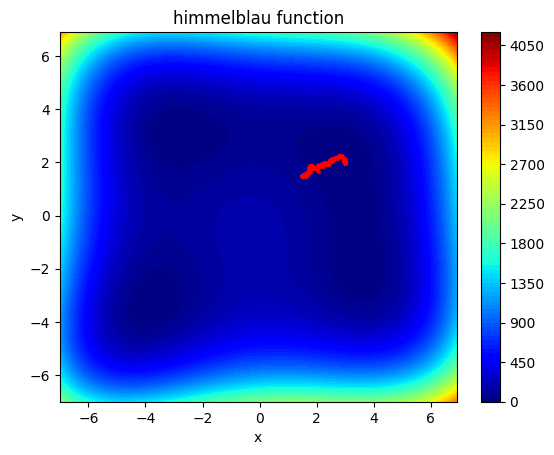

In [195]:
mutation_strength = 0.01

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)



random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


#### Ackley function

##### $\sigma=0.5$

Algorytm zajął: 0.20049s
Step: 8	 Position: [-0.93225, -0.01938]	 Value: 2.59911
Step: 23	 Position: [0.08489, -0.29995]	 Value: 2.26273
Step: 25	 Position: [-0.01493, -0.27943]	 Value: 1.99368
Step: 26	 Position: [-0.07156, -0.16408]	 Value: 1.18974
Step: 32	 Position: [-0.02781, 0.06831]	 Value: 0.34773
Step: 67	 Position: [0.01525, 0.00627]	 Value: 0.05386
Step: 123	 Position: [0.01204, -0.00045]	 Value: 0.03794
Step: 396	 Position: [0.00862, -0.00620]	 Value: 0.03305
Step: 861	 Position: [-0.00360, -0.00755]	 Value: 0.02553


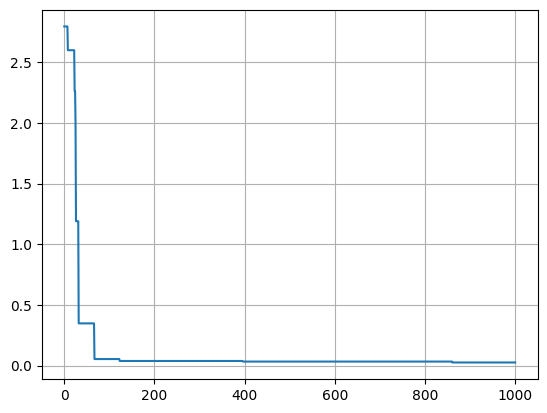

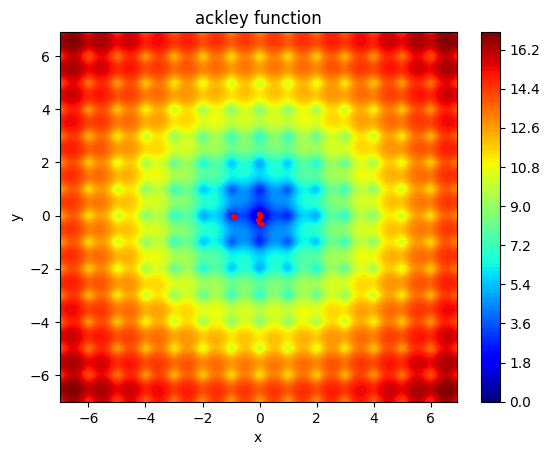

Algorytm zajął: 0.19862s
Step: 2	 Position: [0.47351, -0.04897]	 Value: 3.03682
Step: 10	 Position: [0.01866, 0.08037]	 Value: 0.40525
Step: 17	 Position: [-0.00796, 0.07497]	 Value: 0.35780
Step: 51	 Position: [0.01250, 0.00220]	 Value: 0.04018


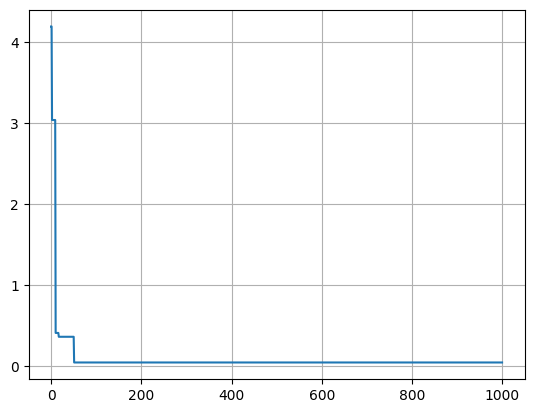

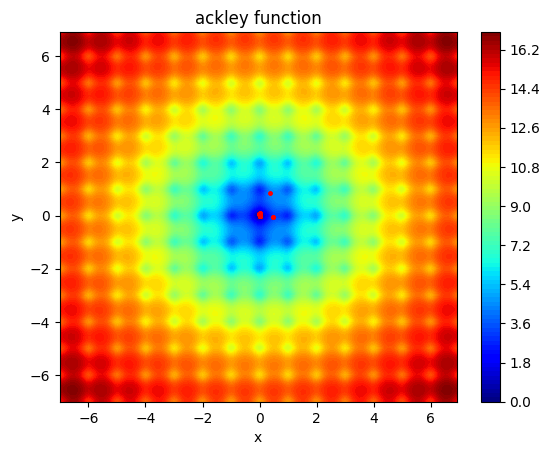

In [196]:
mutation_strength = 0.5

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)



random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


##### $\sigma=0.3$

Algorytm zajął: 0.20037s
Step: 4	 Position: [-0.25579, 0.21625]	 Value: 2.55264
Step: 5	 Position: [-0.12209, -0.03798]	 Value: 0.74685
Step: 9	 Position: [0.05353, 0.06872]	 Value: 0.43851
Step: 37	 Position: [-0.03460, 0.05489]	 Value: 0.29246
Step: 38	 Position: [0.01057, -0.03064]	 Value: 0.11943
Step: 217	 Position: [0.00649, 0.01974]	 Value: 0.07025
Step: 235	 Position: [-0.01026, 0.00964]	 Value: 0.04509
Step: 738	 Position: [-0.00758, 0.00115]	 Value: 0.02326


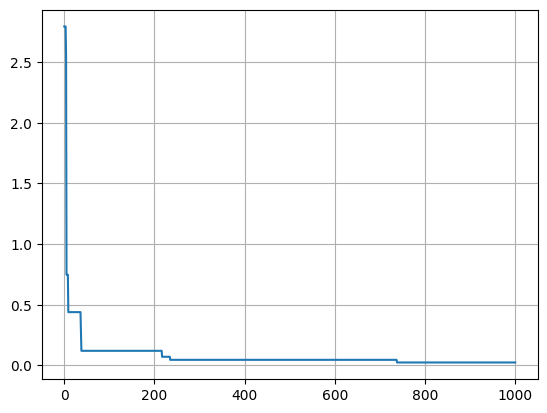

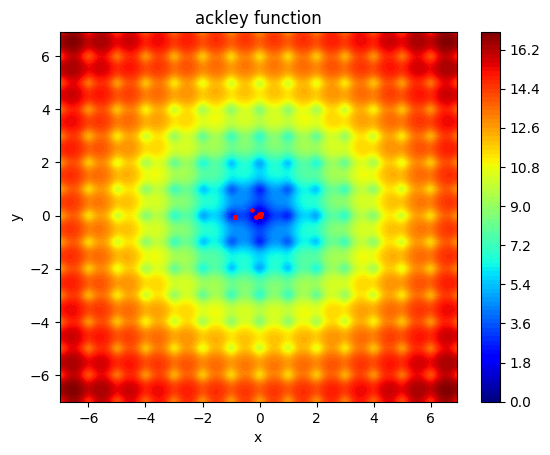

Algorytm zajął: 0.19639s
Step: 2	 Position: [0.29388, 0.30548]	 Value: 3.14628
Step: 3	 Position: [0.29849, 0.12022]	 Value: 2.36940
Step: 5	 Position: [0.01233, 0.31686]	 Value: 2.25277
Step: 13	 Position: [-0.27225, -0.01965]	 Value: 1.94368
Step: 15	 Position: [0.20398, -0.07398]	 Value: 1.51956
Step: 18	 Position: [-0.06805, -0.03055]	 Value: 0.35324
Step: 97	 Position: [0.00404, 0.05880]	 Value: 0.25664
Step: 126	 Position: [-0.04360, -0.00125]	 Value: 0.17322
Step: 175	 Position: [-0.03371, -0.01254]	 Value: 0.13582
Step: 210	 Position: [0.01073, 0.01964]	 Value: 0.07659
Step: 253	 Position: [0.00324, -0.00308]	 Value: 0.01318


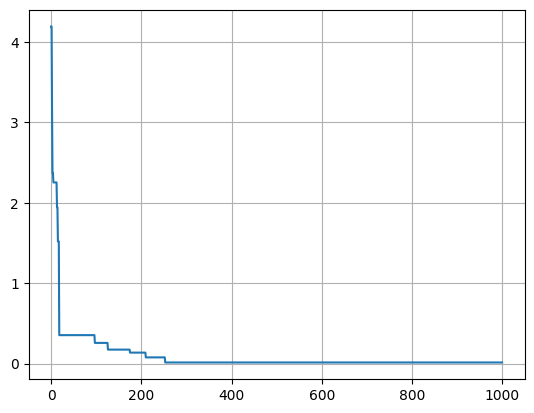

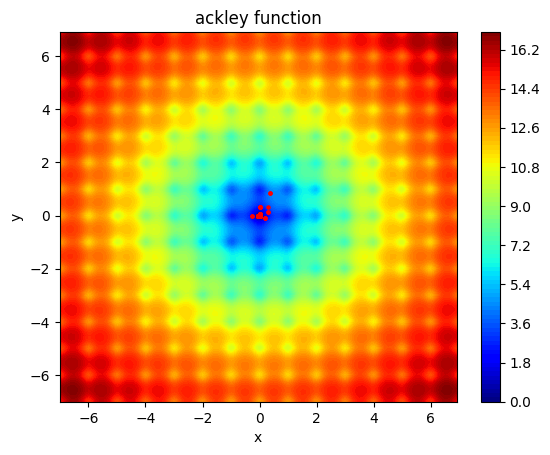

In [197]:
mutation_strength = 0.3

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $\sigma=0.1$

Algorytm zajął: 0.20273s
Step: 3	 Position: [-0.27140, 0.16154]	 Value: 2.37447
Step: 5	 Position: [-0.22684, 0.07679]	 Value: 1.70994
Step: 6	 Position: [-0.23761, -0.03443]	 Value: 1.69173
Step: 7	 Position: [-0.09385, 0.14851]	 Value: 1.16848
Step: 9	 Position: [0.02608, -0.06424]	 Value: 0.31961
Step: 10	 Position: [-0.03523, 0.03736]	 Value: 0.21426
Step: 22	 Position: [-0.00194, 0.00888]	 Value: 0.02792
Step: 52	 Position: [-0.00370, -0.00236]	 Value: 0.01292
Step: 692	 Position: [0.00278, 0.00057]	 Value: 0.00825


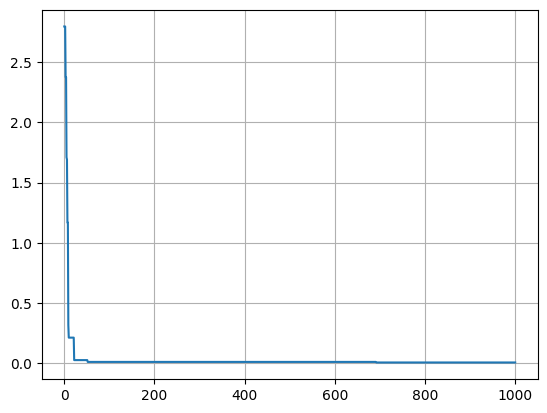

Algorytm zajął: 0.19834s
Step: 2	 Position: [0.08250, 0.80388]	 Value: 3.05536
Step: 3	 Position: [-0.04660, 0.80928]	 Value: 2.94841
Step: 5	 Position: [0.19443, 0.15651]	 Value: 1.84653
Step: 8	 Position: [0.06308, -0.12613]	 Value: 0.86022
Step: 12	 Position: [0.03362, 0.04151]	 Value: 0.22564
Step: 17	 Position: [0.02941, -0.02659]	 Value: 0.15356
Step: 19	 Position: [-0.03928, 0.00137]	 Value: 0.15179
Step: 20	 Position: [0.00956, -0.02270]	 Value: 0.08576
Step: 25	 Position: [0.01627, 0.01506]	 Value: 0.07576
Step: 31	 Position: [-0.01925, -0.00127]	 Value: 0.06443
Step: 48	 Position: [-0.00879, -0.01114]	 Value: 0.04549
Step: 64	 Position: [-0.01147, -0.00157]	 Value: 0.03632
Step: 210	 Position: [0.00334, 0.00916]	 Value: 0.03010
Step: 214	 Position: [0.00068, -0.00955]	 Value: 0.02952
Step: 262	 Position: [-0.00763, -0.00231]	 Value: 0.02424
Step: 266	 Position: [-0.00116, -0.00717]	 Value: 0.02195
Step: 761	 Position: [0.00420, -0.00323]	 Value: 0.01572


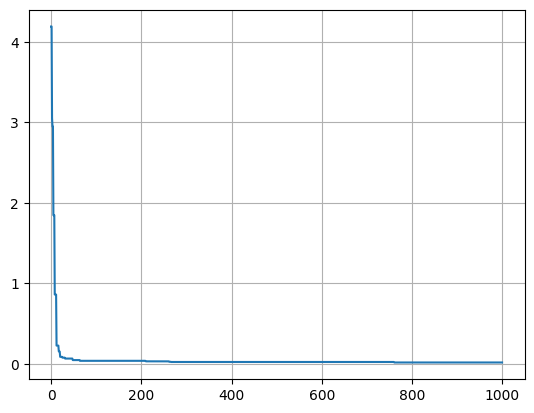

In [198]:
mutation_strength = 0.1

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)

##### $\sigma=0.01$

Algorytm zajął: 0.20105s
Step: 1	 Position: [-0.86292, -0.04990]	 Value: 2.79099
Step: 3	 Position: [-0.86669, -0.03479]	 Value: 2.75043
Step: 5	 Position: [-0.89604, -0.03827]	 Value: 2.68332
Step: 6	 Position: [-0.89192, -0.00590]	 Value: 2.65641
Step: 7	 Position: [-0.92013, 0.00354]	 Value: 2.60316
Step: 9	 Position: [-0.94538, -0.01493]	 Value: 2.58710
Step: 10	 Position: [-0.94176, -0.00001]	 Value: 2.58245
Step: 12	 Position: [-0.95296, 0.00373]	 Value: 2.58033
Step: 22	 Position: [-0.94963, 0.00089]	 Value: 2.58010
Step: 32	 Position: [-0.95046, -0.00079]	 Value: 2.58001
Step: 54	 Position: [-0.95315, 0.00059]	 Value: 2.57996
Step: 383	 Position: [-0.95144, 0.00028]	 Value: 2.57994
Step: 453	 Position: [-0.95150, -0.00029]	 Value: 2.57994
Step: 925	 Position: [-0.95287, 0.00020]	 Value: 2.57994


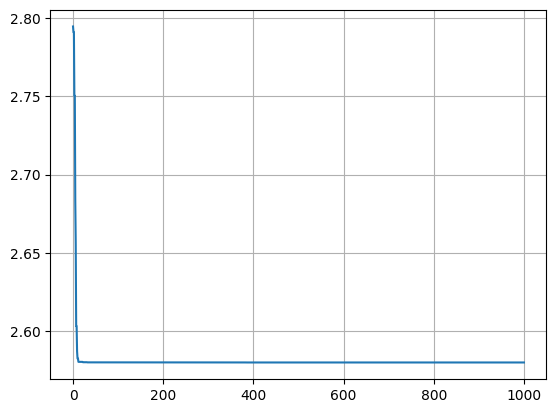

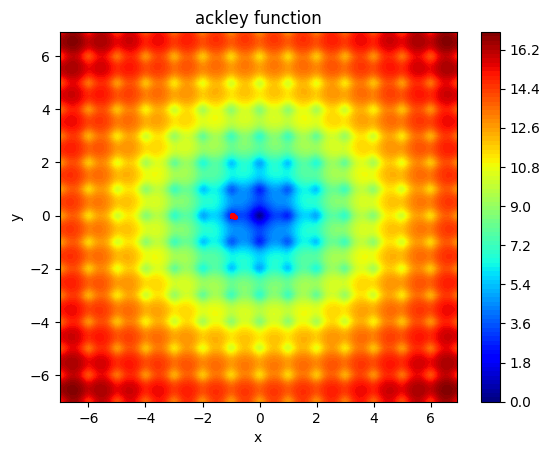

Algorytm zajął: 0.19806s
Step: 2	 Position: [0.24993, -0.41390]	 Value: 3.38858
Step: 5	 Position: [0.29748, 0.24219]	 Value: 2.88962
Step: 6	 Position: [0.30198, 0.20774]	 Value: 2.75736
Step: 7	 Position: [0.26287, 0.21698]	 Value: 2.59487
Step: 8	 Position: [0.27908, 0.13643]	 Value: 2.31119
Step: 10	 Position: [0.27735, 0.11411]	 Value: 2.21053
Step: 12	 Position: [0.26580, 0.11406]	 Value: 2.13241
Step: 13	 Position: [0.25631, 0.10284]	 Value: 2.02298
Step: 14	 Position: [0.26482, 0.06311]	 Value: 1.95969
Step: 15	 Position: [0.22331, 0.09703]	 Value: 1.75741
Step: 16	 Position: [0.21023, 0.09215]	 Value: 1.63743
Step: 17	 Position: [0.20383, 0.08551]	 Value: 1.56097
Step: 18	 Position: [0.18273, 0.08247]	 Value: 1.38192
Step: 19	 Position: [0.15212, 0.07533]	 Value: 1.11029
Step: 21	 Position: [0.13555, 0.07144]	 Value: 0.96590
Step: 22	 Position: [0.13677, 0.06606]	 Value: 0.95305
Step: 23	 Position: [0.10022, 0.07800]	 Value: 0.74568
Step: 26	 Position: [0.03572, 0.04996]	 Valu

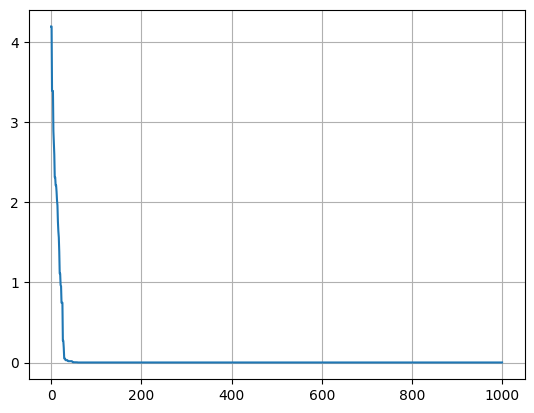

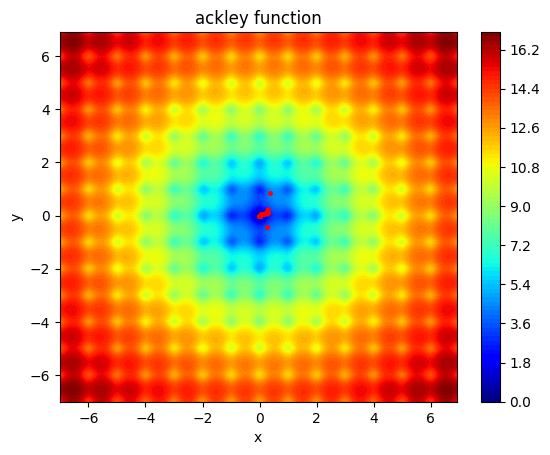

In [199]:
mutation_strength = 0.01

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

### Prawdopodobieństwo krzyżowania $p_c$

In [200]:
restrictions = ((-7,7),(-7,7))
iterations = 1000
size = 20
mutation_strength = 0.3

#### Himmelblau function

##### $p_c=0.5$

Algorytm zajął: 0.09693s
Step: 2	 Position: [3.67575, -2.16031]	 Value: 1.92584
Step: 5	 Position: [-3.60927, -3.19814]	 Value: 1.51729
Step: 6	 Position: [3.62268, -2.06019]	 Value: 0.75584
Step: 7	 Position: [-3.87254, -3.31385]	 Value: 0.47795
Step: 10	 Position: [3.54415, -1.83298]	 Value: 0.08321
Step: 30	 Position: [3.57107, -1.89384]	 Value: 0.04484
Step: 46	 Position: [3.56842, -1.87227]	 Value: 0.02468
Step: 65	 Position: [3.58869, -1.82843]	 Value: 0.00717
Step: 322	 Position: [3.58887, -1.86252]	 Value: 0.00365
Step: 640	 Position: [3.58497, -1.85379]	 Value: 0.00047


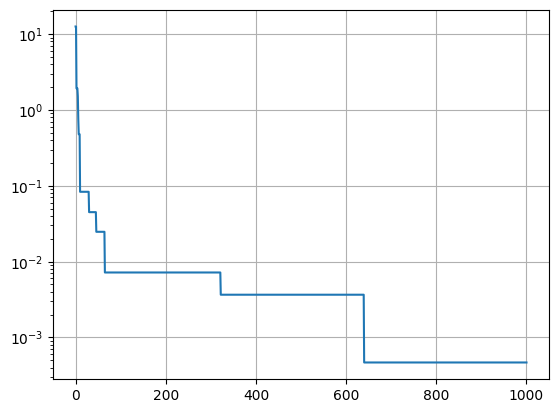

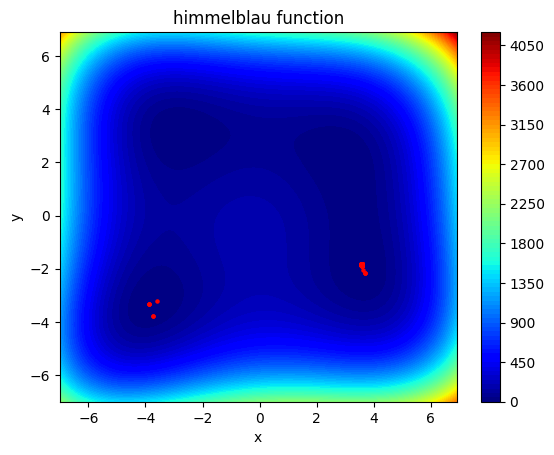

Algorytm zajął: 0.09945s
Step: 1	 Position: [1.59402, 2.78162]	 Value: 37.66950
Step: 5	 Position: [2.25783, 2.15501]	 Value: 14.05123
Step: 8	 Position: [2.42056, 2.25858]	 Value: 8.57991
Step: 9	 Position: [2.66976, 2.22169]	 Value: 3.09159
Step: 12	 Position: [2.81070, 2.39686]	 Value: 2.91438
Step: 13	 Position: [2.84164, 1.83406]	 Value: 1.82174
Step: 14	 Position: [2.90631, 2.23065]	 Value: 0.88225
Step: 15	 Position: [2.99491, 2.06301]	 Value: 0.06401
Step: 18	 Position: [2.96973, 2.00608]	 Value: 0.03053
Step: 45	 Position: [2.98850, 2.01066]	 Value: 0.00437
Step: 77	 Position: [2.99434, 2.01662]	 Value: 0.00403
Step: 157	 Position: [2.99870, 1.99491]	 Value: 0.00063
Step: 794	 Position: [2.99589, 2.00224]	 Value: 0.00053


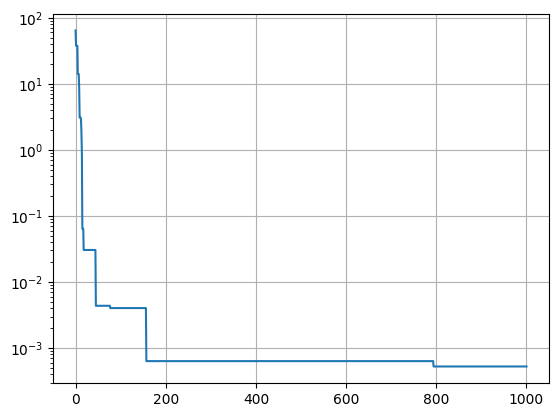

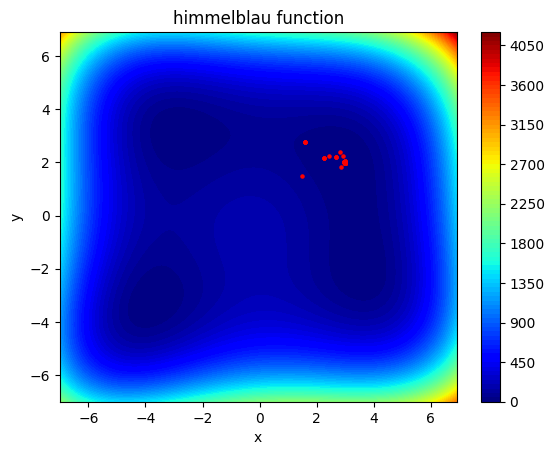

In [201]:
crossover_probability = 0.5

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

##### $p_c=0.3$

Algorytm zajął: 0.09652s
Step: 2	 Position: [3.67575, -2.16031]	 Value: 1.92584
Step: 5	 Position: [-3.60927, -3.19814]	 Value: 1.51729
Step: 6	 Position: [3.62268, -2.06019]	 Value: 0.75584
Step: 7	 Position: [-3.87254, -3.31385]	 Value: 0.47795
Step: 10	 Position: [3.54415, -1.83298]	 Value: 0.08321
Step: 30	 Position: [3.57107, -1.89384]	 Value: 0.04484
Step: 46	 Position: [3.56842, -1.87227]	 Value: 0.02468
Step: 65	 Position: [3.58869, -1.82843]	 Value: 0.00717
Step: 322	 Position: [3.58887, -1.86252]	 Value: 0.00365
Step: 640	 Position: [3.58497, -1.85379]	 Value: 0.00047


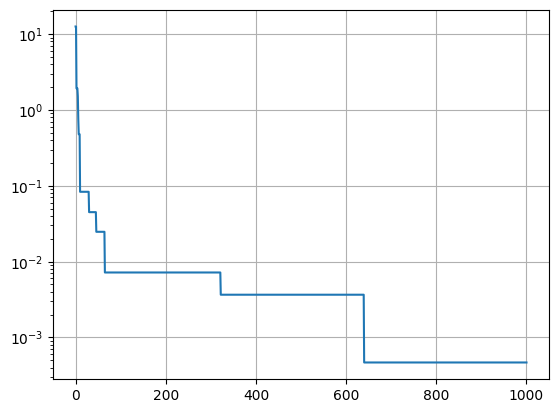

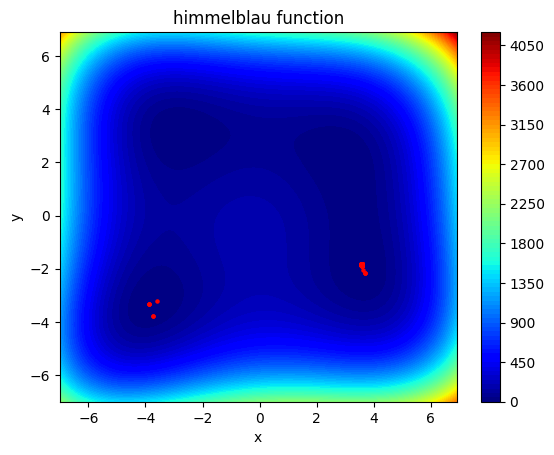

Algorytm zajął: 0.09546s
Step: 1	 Position: [1.59402, 2.78162]	 Value: 37.66950
Step: 5	 Position: [2.25783, 2.15501]	 Value: 14.05123
Step: 8	 Position: [2.42056, 2.25858]	 Value: 8.57991
Step: 9	 Position: [2.66976, 2.22169]	 Value: 3.09159
Step: 12	 Position: [2.81070, 2.39686]	 Value: 2.91438
Step: 13	 Position: [2.84164, 1.83406]	 Value: 1.82174
Step: 14	 Position: [2.90631, 2.23065]	 Value: 0.88225
Step: 15	 Position: [2.99491, 2.06301]	 Value: 0.06401
Step: 18	 Position: [2.96973, 2.00608]	 Value: 0.03053
Step: 45	 Position: [2.98850, 2.01066]	 Value: 0.00437
Step: 77	 Position: [2.99434, 2.01662]	 Value: 0.00403
Step: 157	 Position: [2.99870, 1.99491]	 Value: 0.00063
Step: 794	 Position: [2.99589, 2.00224]	 Value: 0.00053


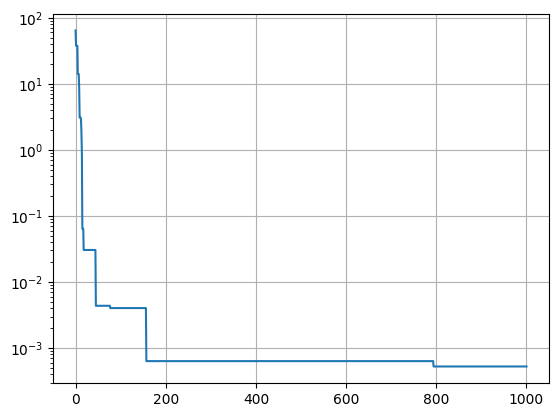

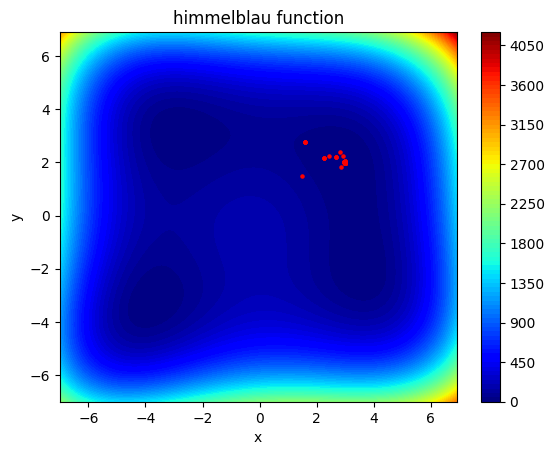

In [202]:
mutation_strength = 0.3

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

##### $p_c=0.1$

Algorytm zajął: 0.09493s
Step: 1	 Position: [3.13297, -1.34468]	 Value: 10.63560
Step: 2	 Position: [3.76087, -2.27651]	 Value: 4.52955
Step: 3	 Position: [3.44747, -2.05748]	 Value: 1.83789
Step: 4	 Position: [3.56398, -1.61943]	 Value: 0.66851
Step: 5	 Position: [3.56409, -1.64725]	 Value: 0.52506
Step: 6	 Position: [3.63189, -1.75296]	 Value: 0.27874
Step: 8	 Position: [3.60863, -1.77948]	 Value: 0.10947
Step: 10	 Position: [3.59922, -1.84759]	 Value: 0.01158
Step: 18	 Position: [3.59106, -1.83584]	 Value: 0.00508
Step: 28	 Position: [3.58729, -1.83335]	 Value: 0.00390
Step: 100	 Position: [3.58983, -1.84651]	 Value: 0.00163
Step: 104	 Position: [3.58598, -1.84099]	 Value: 0.00095
Step: 125	 Position: [3.58235, -1.84956]	 Value: 0.00028
Step: 262	 Position: [3.58669, -1.84897]	 Value: 0.00027


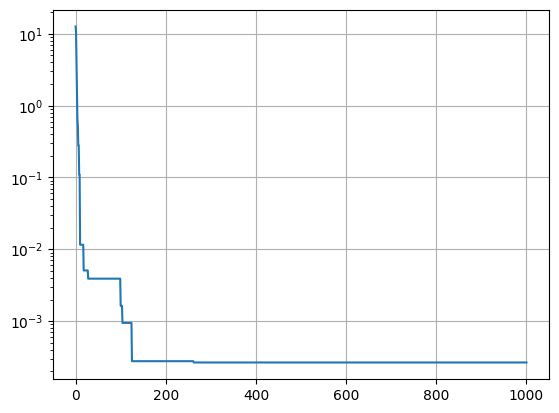

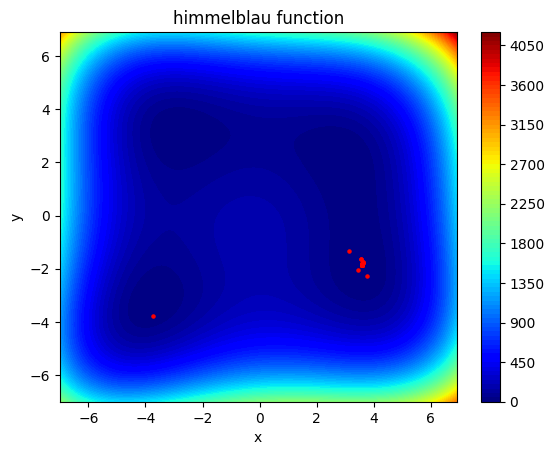

Algorytm zajął: 0.09650s
Step: 1	 Position: [2.16612, 2.81134]	 Value: 21.64943
Step: 2	 Position: [2.16749, 2.61057]	 Value: 17.55710
Step: 8	 Position: [2.22173, 2.64509]	 Value: 16.60883
Step: 9	 Position: [2.21015, 2.58293]	 Value: 16.01777
Step: 10	 Position: [2.64420, 2.53633]	 Value: 6.48118
Step: 12	 Position: [2.59078, 2.45451]	 Value: 5.97059
Step: 13	 Position: [2.70149, 2.40712]	 Value: 3.91380
Step: 15	 Position: [2.76037, 2.31135]	 Value: 2.35871
Step: 16	 Position: [2.89375, 2.32452]	 Value: 1.77362
Step: 18	 Position: [2.86107, 2.24135]	 Value: 1.11095
Step: 19	 Position: [2.89473, 2.25275]	 Value: 1.07541
Step: 20	 Position: [2.95120, 2.22515]	 Value: 0.81872
Step: 21	 Position: [2.96525, 2.14538]	 Value: 0.32635
Step: 24	 Position: [3.01380, 2.09586]	 Value: 0.19716
Step: 25	 Position: [3.04660, 2.04908]	 Value: 0.16967
Step: 26	 Position: [2.99173, 2.02247]	 Value: 0.00747
Step: 46	 Position: [2.98747, 2.00476]	 Value: 0.00498
Step: 52	 Position: [3.00846, 2.00742]	 

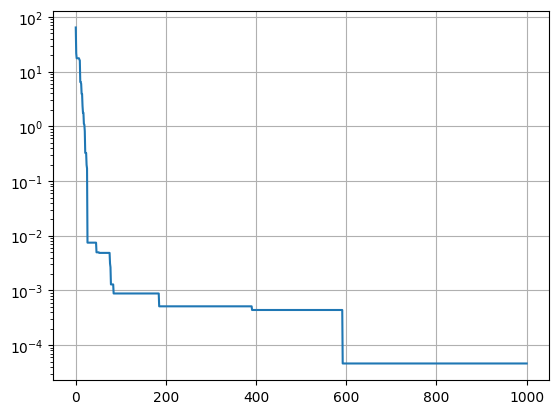

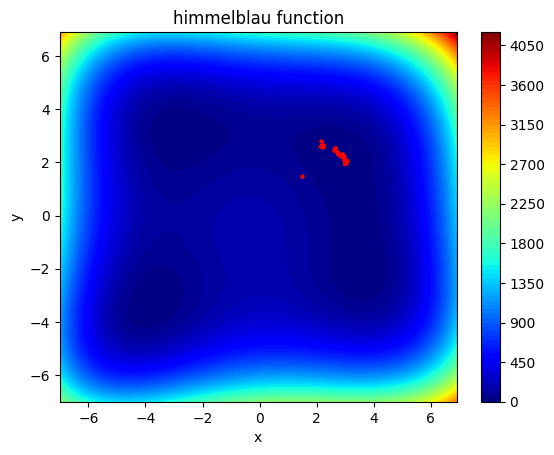

In [203]:
mutation_strength = 0.1

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)


random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

##### $p_c=0.01$

Algorytm zajął: 0.09984s
Step: 1	 Position: [3.17110, -1.21463]	 Value: 10.19938
Step: 2	 Position: [3.33895, -1.19625]	 Value: 6.07070
Step: 3	 Position: [3.44851, -1.09997]	 Value: 5.52610
Step: 4	 Position: [3.78014, -1.43239]	 Value: 4.81335
Step: 5	 Position: [3.56681, -1.35899]	 Value: 2.64837
Step: 8	 Position: [3.55747, -1.36328]	 Value: 2.59450
Step: 9	 Position: [3.55833, -1.37402]	 Value: 2.49685
Step: 10	 Position: [3.56162, -1.37957]	 Value: 2.45012
Step: 12	 Position: [3.55553, -1.38051]	 Value: 2.43577
Step: 14	 Position: [3.56137, -1.38777]	 Value: 2.37569
Step: 15	 Position: [3.56894, -1.39712]	 Value: 2.30356
Step: 17	 Position: [3.54005, -1.41336]	 Value: 2.15256
Step: 18	 Position: [3.52523, -1.44628]	 Value: 1.91317
Step: 20	 Position: [3.53140, -1.44985]	 Value: 1.86790
Step: 21	 Position: [3.52789, -1.45796]	 Value: 1.81310
Step: 23	 Position: [3.55893, -1.47237]	 Value: 1.65851
Step: 24	 Position: [3.56363, -1.48470]	 Value: 1.56400
Step: 25	 Position: [3.55723,

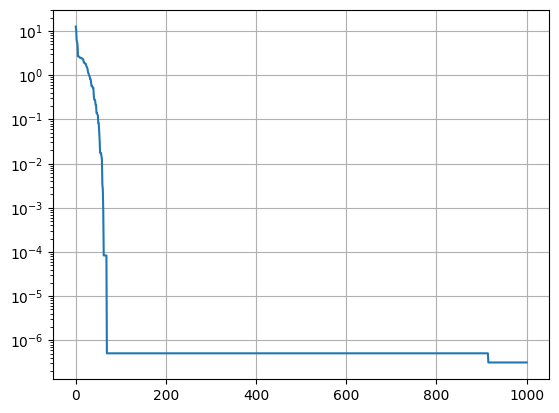

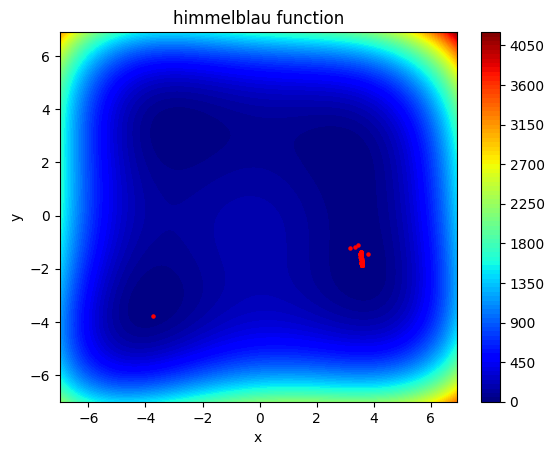

Algorytm zajął: 0.10005s
Step: 1	 Position: [2.42357, 2.82471]	 Value: 16.87482
Step: 2	 Position: [2.42371, 2.80463]	 Value: 16.20911
Step: 6	 Position: [2.38480, 2.35546]	 Value: 9.61591
Step: 8	 Position: [2.39022, 2.35891]	 Value: 9.48412
Step: 10	 Position: [2.43363, 2.35425]	 Value: 8.36865
Step: 13	 Position: [2.43402, 2.33315]	 Value: 8.29102
Step: 15	 Position: [2.46161, 2.32934]	 Value: 7.60567
Step: 19	 Position: [2.49474, 2.35816]	 Value: 6.96165
Step: 20	 Position: [2.49260, 2.33744]	 Value: 6.91445
Step: 21	 Position: [2.50178, 2.37440]	 Value: 6.89986
Step: 22	 Position: [2.50887, 2.36590]	 Value: 6.69799
Step: 23	 Position: [2.51912, 2.35220]	 Value: 6.40512
Step: 24	 Position: [2.52394, 2.35812]	 Value: 6.33676
Step: 25	 Position: [2.52310, 2.33915]	 Value: 6.25568
Step: 26	 Position: [2.53647, 2.35487]	 Value: 6.06103
Step: 27	 Position: [2.54863, 2.34864]	 Value: 5.78138
Step: 28	 Position: [2.55793, 2.33841]	 Value: 5.54128
Step: 29	 Position: [2.57568, 2.33600]	 Va

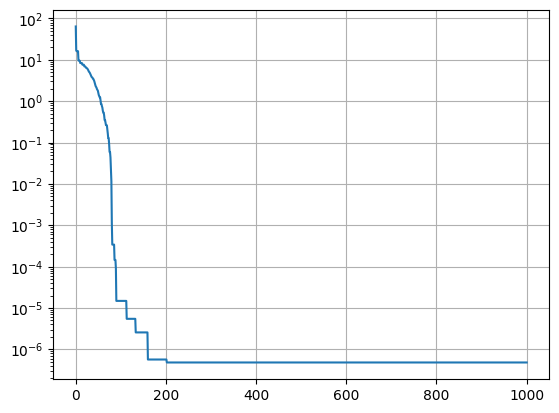

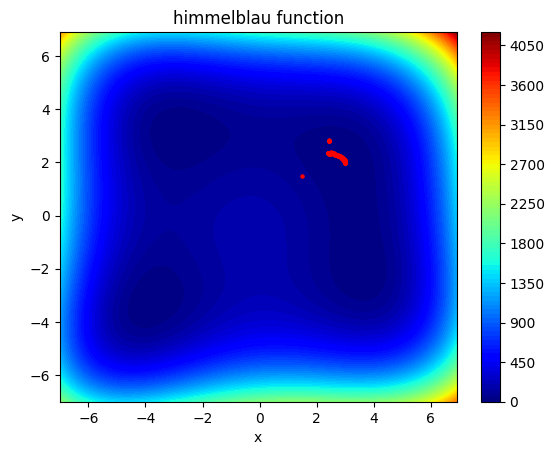

In [204]:
mutation_strength = 0.01

random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(himmelblau_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace,True)
plot_trace(himmelblau_function,trace)

#### Ackley function

##### $p_c=0.5$

Algorytm zajął: 0.21168s
Step: 4	 Position: [0.22512, -0.00436]	 Value: 1.56327
Step: 6	 Position: [0.05451, -0.07190]	 Value: 0.46054
Step: 13	 Position: [-0.05924, -0.00514]	 Value: 0.25965
Step: 16	 Position: [-0.00031, 0.02294]	 Value: 0.07883
Step: 68	 Position: [-0.00352, -0.01085]	 Value: 0.03573
Step: 413	 Position: [-0.00511, -0.00417]	 Value: 0.01982


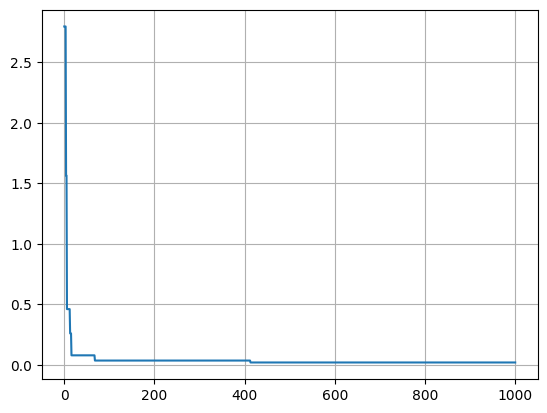

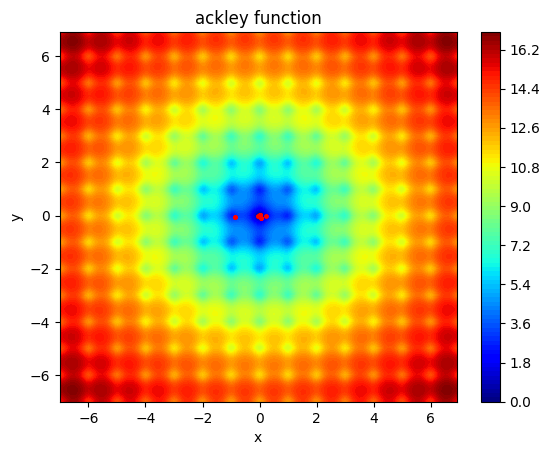

Algorytm zajął: 0.20589s
Step: 2	 Position: [0.36737, -0.15672]	 Value: 2.87458
Step: 4	 Position: [-0.29777, -0.19422]	 Value: 2.67486
Step: 5	 Position: [0.09888, -0.30466]	 Value: 2.33502
Step: 6	 Position: [0.23884, -0.13357]	 Value: 2.03115
Step: 7	 Position: [-0.07886, 0.21790]	 Value: 1.64704
Step: 10	 Position: [-0.12570, 0.05919]	 Value: 0.84189
Step: 11	 Position: [-0.05388, 0.08087]	 Value: 0.51077
Step: 14	 Position: [0.01949, 0.07271]	 Value: 0.35734
Step: 22	 Position: [-0.01478, -0.02756]	 Value: 0.11433
Step: 77	 Position: [-0.00504, -0.01763]	 Value: 0.06079
Step: 438	 Position: [-0.00885, -0.00736]	 Value: 0.03608
Step: 652	 Position: [0.00530, 0.00798]	 Value: 0.02953
Step: 690	 Position: [0.00510, 0.00549]	 Value: 0.02268


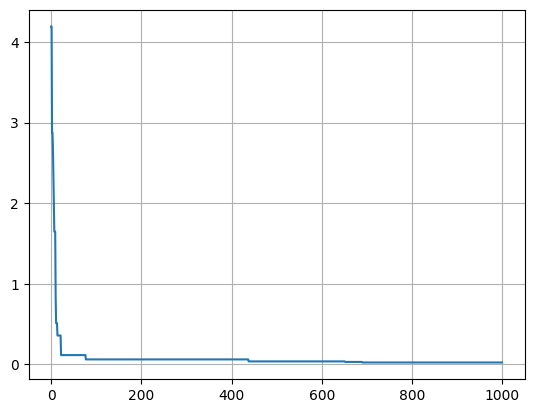

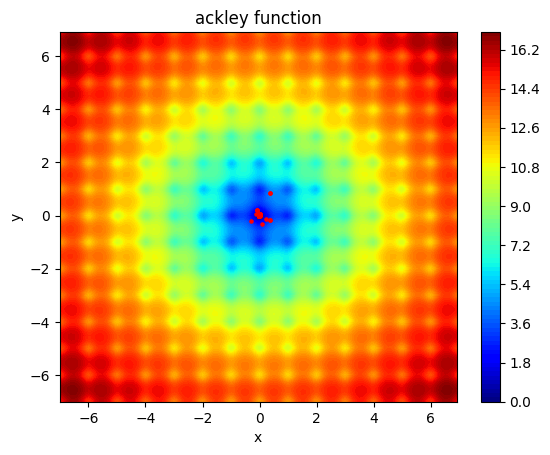

In [205]:
mutation_strength = 0.5


random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)
random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.3$

Algorytm zajął: 0.20792s
Step: 3	 Position: [-0.14008, -0.16975]	 Value: 1.58041
Step: 5	 Position: [-0.09514, -0.19684]	 Value: 1.54611
Step: 6	 Position: [-0.19314, -0.06964]	 Value: 1.41726
Step: 7	 Position: [-0.00998, -0.04864]	 Value: 0.20481
Step: 34	 Position: [0.01998, -0.03038]	 Value: 0.13773
Step: 46	 Position: [0.01733, -0.00882]	 Value: 0.06504
Step: 117	 Position: [0.01296, -0.00759]	 Value: 0.04848
Step: 158	 Position: [0.00371, -0.00937]	 Value: 0.03120
Step: 309	 Position: [-0.00559, 0.00727]	 Value: 0.02819


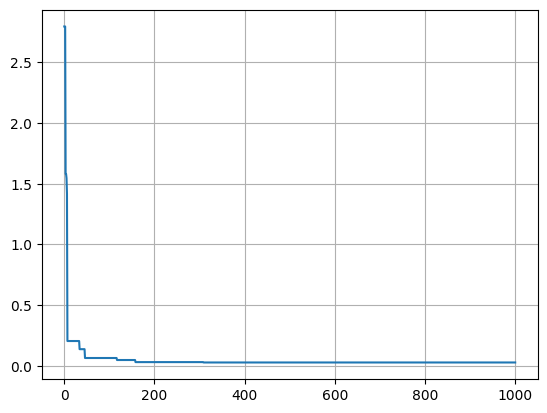

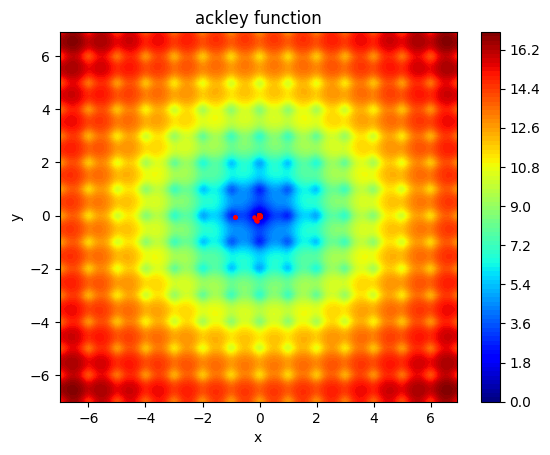

Algorytm zajął: 0.21318s
Step: 2	 Position: [0.36464, 0.24482]	 Value: 3.19190
Step: 5	 Position: [0.34945, 0.02949]	 Value: 2.46589
Step: 6	 Position: [0.01361, -0.31791]	 Value: 2.26023
Step: 7	 Position: [0.02977, 0.16432]	 Value: 1.07312
Step: 12	 Position: [-0.13047, -0.08116]	 Value: 0.97201
Step: 13	 Position: [0.02822, -0.00736]	 Value: 0.10498
Step: 89	 Position: [0.01807, 0.00691]	 Value: 0.06466
Step: 220	 Position: [-0.00830, -0.01224]	 Value: 0.04765
Step: 575	 Position: [0.00877, -0.00522]	 Value: 0.03163


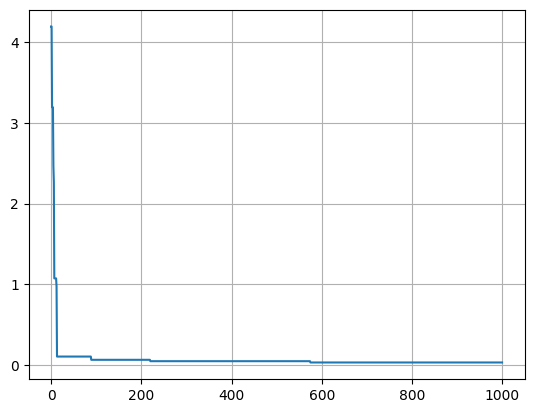

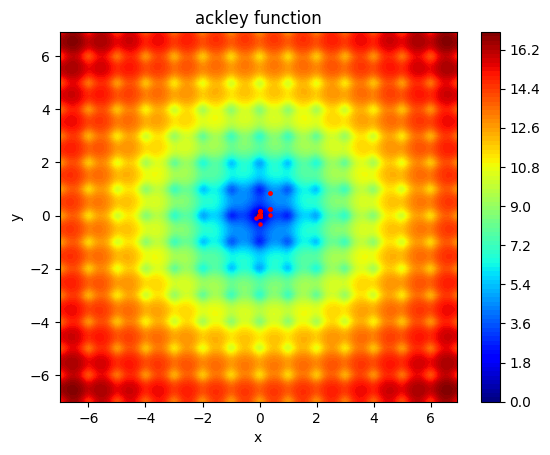

In [206]:
mutation_strength = 0.3


random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.1$

Algorytm zajął: 0.21471s
Step: 1	 Position: [-0.93741, -0.07820]	 Value: 2.74330
Step: 4	 Position: [-0.11279, 0.03500]	 Value: 0.66840
Step: 5	 Position: [-0.09781, 0.02597]	 Value: 0.53824
Step: 7	 Position: [-0.03675, 0.03297]	 Value: 0.20352
Step: 10	 Position: [-0.02243, 0.01784]	 Value: 0.10283
Step: 13	 Position: [-0.01632, -0.00419]	 Value: 0.05522
Step: 24	 Position: [-0.01029, -0.00245]	 Value: 0.03290
Step: 63	 Position: [-0.00517, 0.00634]	 Value: 0.02492
Step: 100	 Position: [-0.00264, -0.00682]	 Value: 0.02210
Step: 104	 Position: [-0.00111, -0.00302]	 Value: 0.00938
Step: 389	 Position: [-0.00161, -0.00268]	 Value: 0.00910
Step: 459	 Position: [0.00266, 0.00051]	 Value: 0.00784
Step: 550	 Position: [0.00131, 0.00173]	 Value: 0.00627
Step: 592	 Position: [-0.00071, -0.00104]	 Value: 0.00361


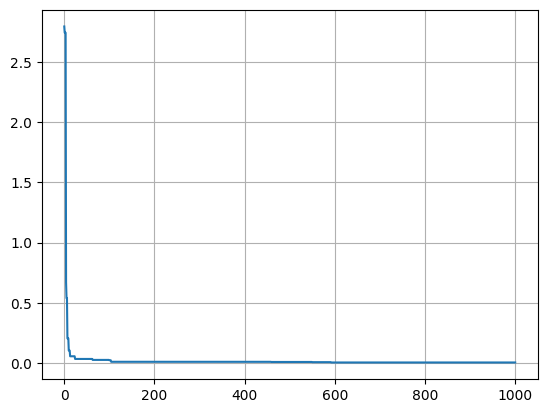

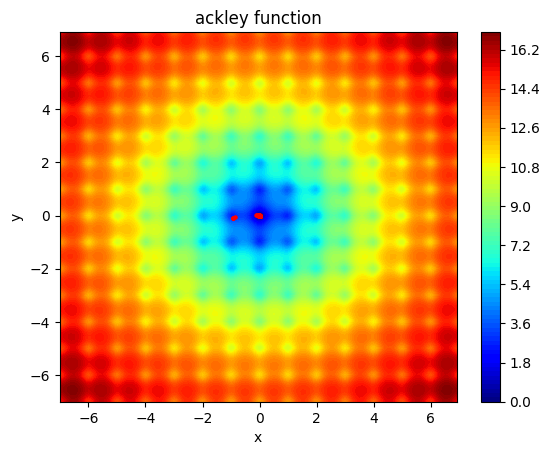

Algorytm zajął: 0.20663s
Step: 2	 Position: [-0.34319, 0.85173]	 Value: 4.13178
Step: 3	 Position: [-0.05309, 0.35420]	 Value: 2.52319
Step: 6	 Position: [-0.11127, -0.00457]	 Value: 0.61386
Step: 7	 Position: [0.00646, 0.04481]	 Value: 0.18176
Step: 10	 Position: [-0.02759, 0.02663]	 Value: 0.14723
Step: 12	 Position: [-0.03358, 0.00249]	 Value: 0.12517
Step: 13	 Position: [-0.01786, 0.01081]	 Value: 0.07062
Step: 15	 Position: [-0.01221, 0.00566]	 Value: 0.04288
Step: 17	 Position: [0.00460, 0.01144]	 Value: 0.03893
Step: 42	 Position: [-0.00233, -0.00668]	 Value: 0.02134
Step: 77	 Position: [-0.00038, -0.00469]	 Value: 0.01391
Step: 202	 Position: [-0.00074, 0.00258]	 Value: 0.00779
Step: 349	 Position: [-0.00137, -0.00120]	 Value: 0.00523


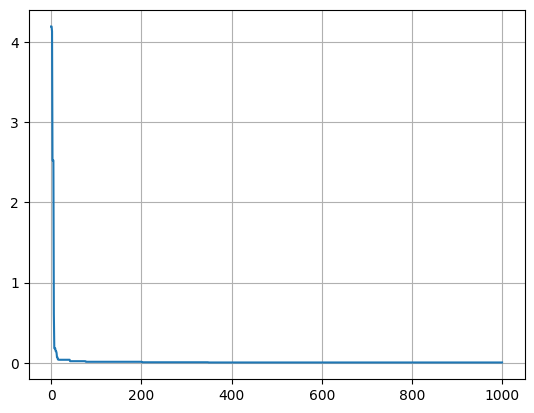

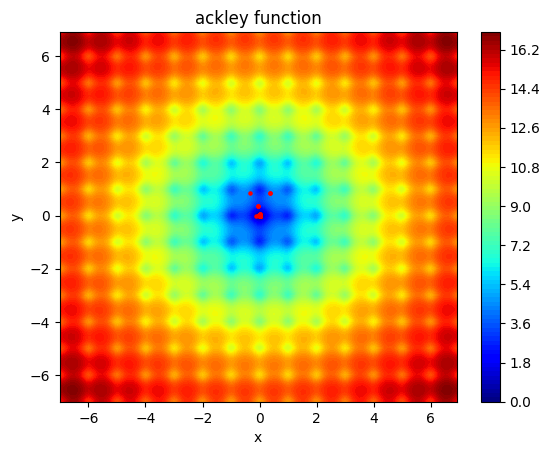

In [207]:
mutation_strength = 0.1


random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

##### $p_c=0.01$

Algorytm zajął: 0.21623s
Step: 1	 Position: [-0.87636, -0.06059]	 Value: 2.78254
Step: 4	 Position: [-0.88925, -0.05253]	 Value: 2.73009
Step: 6	 Position: [-0.90327, -0.04697]	 Value: 2.68740
Step: 7	 Position: [-0.90895, -0.04445]	 Value: 2.67140
Step: 8	 Position: [-0.92247, -0.04434]	 Value: 2.65133
Step: 9	 Position: [-0.93065, -0.04058]	 Value: 2.63428
Step: 10	 Position: [-0.91981, -0.02713]	 Value: 2.62271
Step: 11	 Position: [-0.93579, -0.01834]	 Value: 2.59519
Step: 12	 Position: [-0.93861, 0.00224]	 Value: 2.58432
Step: 13	 Position: [-0.94197, -0.00079]	 Value: 2.58237
Step: 14	 Position: [-0.94644, -0.00034]	 Value: 2.58070
Step: 18	 Position: [-0.95511, -0.00415]	 Value: 2.58061
Step: 20	 Position: [-0.94992, -0.00273]	 Value: 2.58025
Step: 22	 Position: [-0.95385, -0.00047]	 Value: 2.58000
Step: 46	 Position: [-0.95197, -0.00087]	 Value: 2.57995
Step: 51	 Position: [-0.95223, 0.00037]	 Value: 2.57993
Step: 147	 Position: [-0.95181, -0.00005]	 Value: 2.57993
Step: 181	 Po

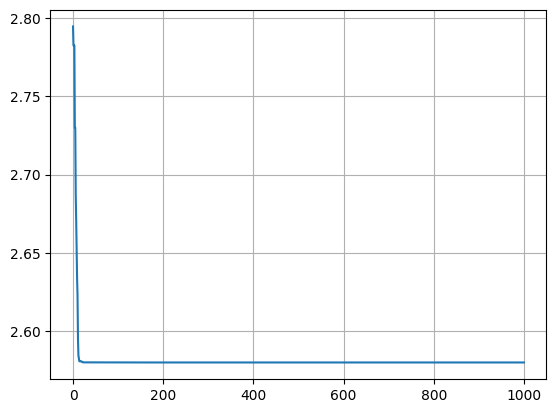

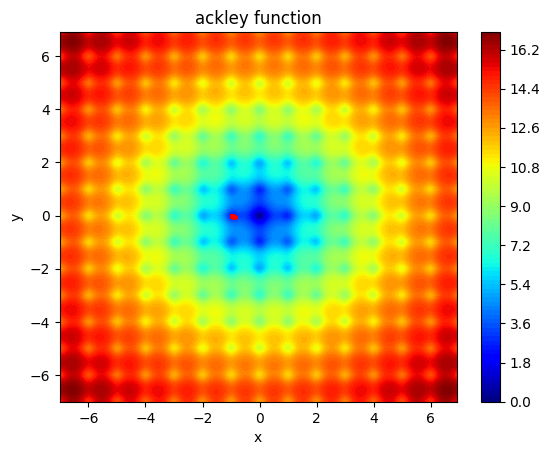

Algorytm zajął: 0.20499s
Step: 2	 Position: [-0.33525, 0.82798]	 Value: 4.11146
Step: 3	 Position: [0.15689, -1.14487]	 Value: 3.94242
Step: 4	 Position: [0.17288, 0.07415]	 Value: 1.27022
Step: 7	 Position: [0.10181, -0.01094]	 Value: 0.54631
Step: 8	 Position: [0.07709, 0.05380]	 Value: 0.48765
Step: 9	 Position: [0.05208, 0.06489]	 Value: 0.41144
Step: 10	 Position: [0.05956, 0.04873]	 Value: 0.36930
Step: 11	 Position: [0.05938, 0.02806]	 Value: 0.29708
Step: 12	 Position: [0.05404, 0.01988]	 Value: 0.24895
Step: 14	 Position: [0.04332, 0.01177]	 Value: 0.17978
Step: 15	 Position: [0.02490, 0.03157]	 Value: 0.15633
Step: 16	 Position: [0.02885, -0.01324]	 Value: 0.11643
Step: 17	 Position: [0.02036, 0.01116]	 Value: 0.07996
Step: 18	 Position: [0.00617, 0.01685]	 Value: 0.05929
Step: 19	 Position: [0.00337, 0.01010]	 Value: 0.03312
Step: 20	 Position: [0.00754, -0.00278]	 Value: 0.02445
Step: 21	 Position: [0.00288, 0.00034]	 Value: 0.00843
Step: 22	 Position: [0.00017, -0.00063]	 

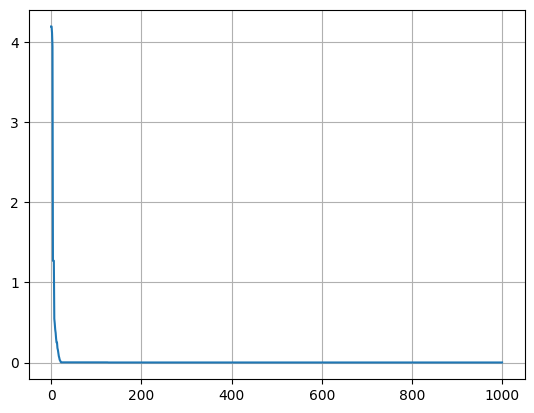

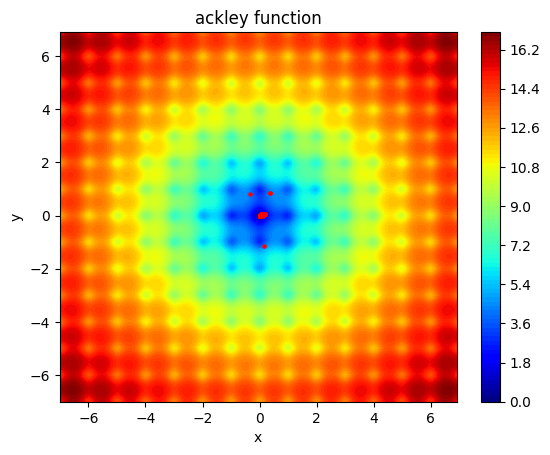

In [208]:
mutation_strength = 0.01


random.seed(1)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)

random.seed(2)
population = generate_population(size,restrictions)
t1 = time.time() 
trace = evolutionary_algorithm(ackley_function,population,iterations,mutation_strength,crossover_probability)
t2 = time.time()
print(f"Algorytm zajął: {t2-t1:.5f}s")
print_trace(trace)
plot_values(trace)
plot_trace(ackley_function,trace)